In [13]:
import pandas as pd
import datetime as dt
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
!pip install gdown

In [14]:
!gdown "https://drive.google.com/uc?id=1EqS5vja_WAvdV3If3Zunv6t9P4p56dDA" ###crop file download

Downloading...
From: https://drive.google.com/uc?id=1EqS5vja_WAvdV3If3Zunv6t9P4p56dDA
To: /content/crop_df.csv
100% 2.20M/2.20M [00:00<00:00, 167MB/s]


In [15]:
crop_df = pd.read_csv("crop_df.csv") ###crop_df file read
#crop_df.set_index('Year', inplace=True) ###set index as year
crop_df.head()

,Year,FarmName,Crop,StrainName,Plot,Rootstock,Station,maxTemp_April,maxTemp_May,maxTemp_June,...,ChillHours,HeatWave_RH,HeatWaveDays_Day_VPD,HeatWaveDays_Night_VPD,HeatWaveCount_Day_VPD,HeatWaveCount_Night_VPD,HeatWaveFYDays_Day_Temp,HeatWaveFYDays_Night_Temp,HeatWaveFYCount_Day_Temp,HeatWaveFYCount_Night_Temp
0,2001,Ortal,5.36,Golden,Unique_1,semi vigorous,ElRomA,30.2,34.5,35.5,...,2098.5,8,8,13,3,4,0,4,3,0
1,2002,Ortal,6.20,Golden,Unique_1,semi vigorous,ElRomA,25.8,32.3,37.1,...,1307.5,0,47,73,12,14,8,0,11,8
2,2003,Ortal,7.68,Golden,Unique_1,semi vigorous,ElRomA,30.4,33.1,38.1,...,532.5,0,57,56,15,14,79,111,16,20
3,2004,Ortal,5.50,Golden,Unique_1,semi vigorous,ElRomA,33.7,38.5,37.0,...,520.5,0,51,61,16,15,67,111,20,19
4,2005,Ortal,4.70,Golden,Unique_1,semi vigorous,ElRomA,35.3,38.8,37.8,...,367.5,0,46,36,12,11,72,94,17,11


In [16]:

def calculate_95_percentile(dataframe):
    """
    Calculate the 95th percentile of the Crop column for each StrainName.

    :param dataframe: DataFrame containing 'StrainName' and 'Crop' columns.
    :return: Dictionary with StrainName as keys and 95th percentile as values.
    """
    # Group by 'StrainName' and calculate the 95th percentile of 'Crop'
    percentile_dict = dataframe.groupby('StrainName')['Crop'].quantile(0.95).to_dict()

    return percentile_dict



# Calculate the 95th percentile dictionary
percentile_dict = calculate_95_percentile(crop_df)

# Remove rows where Crop is greater than the 95th percentile for the corresponding StrainName
def remove_above_percentile(dataframe, percentile_dict):
    """
    Remove rows where the Crop value is greater than the 95th percentile for the corresponding StrainName.

    :param dataframe: DataFrame containing 'StrainName' and 'Crop' columns.
    :param percentile_dict: Dictionary with StrainName as keys and 95th percentile as values.
    :return: Filtered DataFrame.
    """
    filtered_df = dataframe[dataframe.apply(lambda row: row['Crop'] <= percentile_dict[row['StrainName']], axis=1)]
    return filtered_df


# Apply the filter to remove rows
crop_df = remove_above_percentile(crop_df, percentile_dict)

In [17]:
crop_df[['Rootstock', 'StrainName']].value_counts().reset_index(name='count')

,Rootstock,StrainName,count
0,very vigorous,Golden,2407
1,very vigorous,Smith,2011
2,very vigorous,Starking,1660
3,semi vigorous,Smith,1501
4,semi vigorous,Golden,1497
...,...,...,...
64,dwarfing,Martina,1
65,unknown,Acen,1
66,semi vigorous,Arian,1
67,unknown,NothingLikeHim,1


In [18]:
crop_df = crop_df[crop_df['Crop'] >=0.5]

In [19]:
top_6_strains = crop_df['StrainName'].value_counts().head(6).index
crop_df = crop_df[crop_df['StrainName'].isin(top_6_strains)]
len(crop_df)

16068

In [20]:
upper_threshold = {
    "Golden": 1200,
    "Starking": 1200,
    "Gala": 1200,
    "Azrak": 1200,
    "Smith": 800,
    "PinkLady": 800
}

# Replace chill hour values exceeding the upper threshold
def adjust_chill_hours(row):
    variety = row["StrainName"]
    chill_hours = row["ChillHours"]

    if variety in upper_threshold:
        # Replace only if variety exists in the threshold dictionary
        return min(chill_hours, upper_threshold[variety])
    return chill_hours  # Keep original value if variety is not in the dictionary

crop_df["ChillHours"] = crop_df.apply(adjust_chill_hours, axis=1)

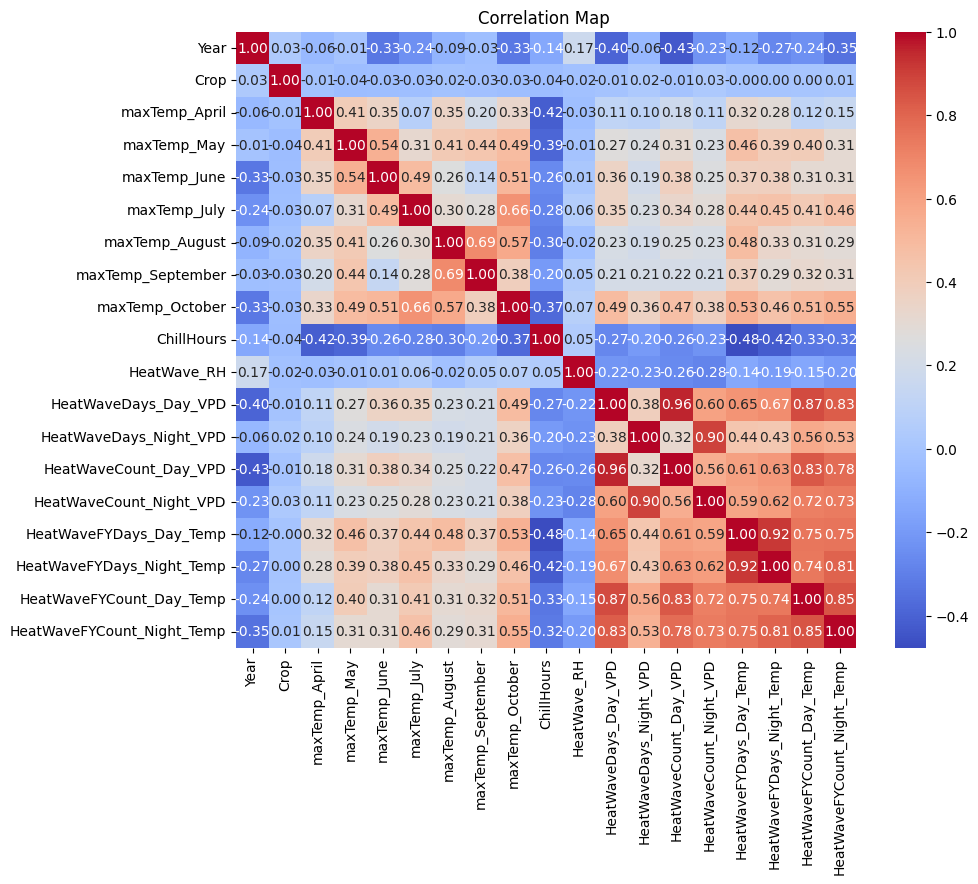

In [21]:
columns = crop_df.select_dtypes(include=['number']).columns
corr_matrix = crop_df[columns].corr()

 # Step 4: Plot the correlation matrix.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Map ')
plt.show()

In [22]:
import numpy as np

# Threshold values for correlations
threshold_min = 0.75
threshold_max = 1.0

# Mask diagonal and lower triangle to avoid duplicates
corr_matrix_filtered = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = corr_matrix_filtered.stack()

# Filter pairs by absolute value within the desired range
result = pairs[(pairs.abs() > threshold_min) & (pairs.abs() < threshold_max)]

# Dictionary to store correlations of each column with "Crop"
# Assuming you have this correlation data as a dictionary
corr_with_crop = {
    col: corr_matrix.loc["Crop", col] for col in corr_matrix.columns if col != "Crop"
}

# Sets to track columns to keep
columns_to_keep = set(corr_with_crop.keys())

# Iteratively remove columns with high correlations
for col_pair, corr_value in result.items():
    col1, col2 = col_pair

    # Only proceed if both columns are still in the columns_to_keep set
    if col1 in columns_to_keep and col2 in columns_to_keep:
        # Compare correlations with "Crop" and remove the one with the lower correlation
        if corr_with_crop[col1] >= corr_with_crop[col2]:
            columns_to_keep.remove(col2)
        else:
            columns_to_keep.remove(col1)

# Final printout
print("Columns to keep:", columns_to_keep)

# Drop the columns that are not in the final keep list
columns_to_remove = set(corr_matrix.columns) - columns_to_keep - {"Crop"}
crop_df = crop_df.drop(columns=columns_to_remove)


Columns to keep: {'maxTemp_June', 'maxTemp_September', 'maxTemp_April', 'maxTemp_October', 'ChillHours', 'HeatWave_RH', 'maxTemp_May', 'HeatWaveCount_Night_VPD', 'Year', 'HeatWaveFYCount_Night_Temp', 'maxTemp_July', 'maxTemp_August'}


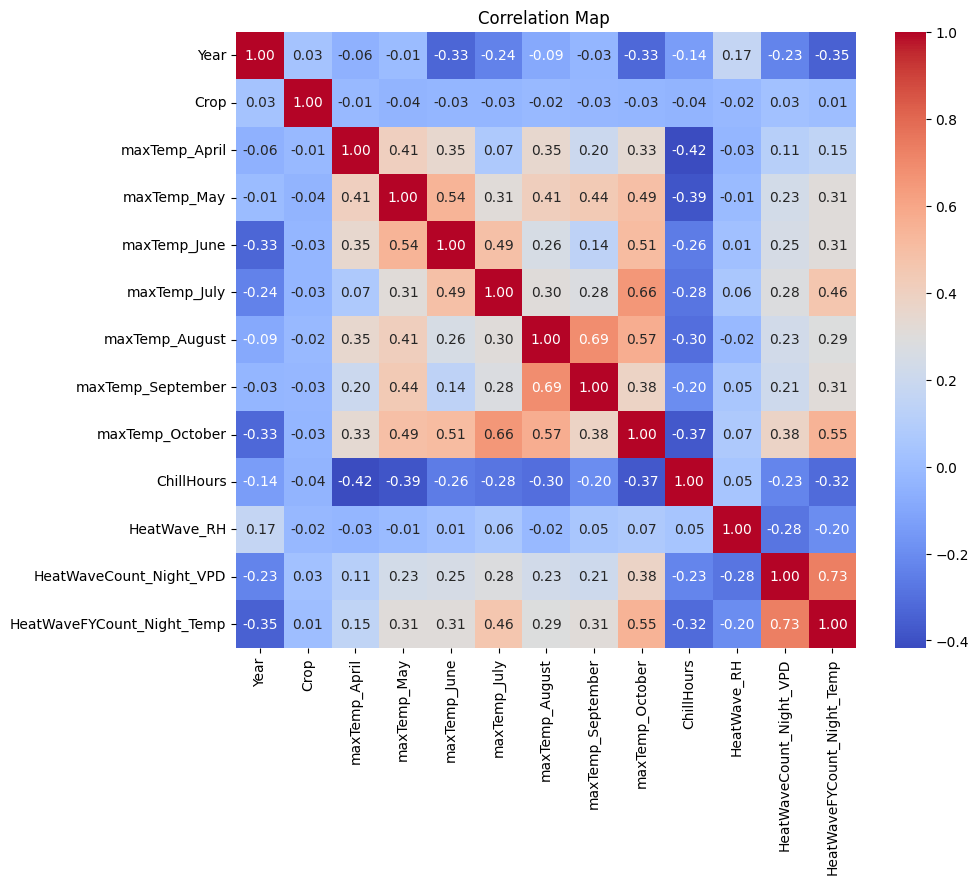

In [23]:
columns = crop_df.select_dtypes(include=['number']).columns
corr_matrix = crop_df[columns].corr()

 # Step 4: Plot the correlation matrix.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Map ')
plt.show()

In [24]:
numeric_cols =[col for col in crop_df.columns if crop_df[col].dtypes != 'object' and col != 'Crop'  and col != 'Year']
y = crop_df.Crop
X = crop_df[numeric_cols]
X

,maxTemp_April,maxTemp_May,maxTemp_June,maxTemp_July,maxTemp_August,maxTemp_September,maxTemp_October,ChillHours,HeatWave_RH,HeatWaveCount_Night_VPD,HeatWaveFYCount_Night_Temp
0,30.2,34.5,35.5,32.7,33.2,33.7,31.4,1200.0,8,4,0
1,25.8,32.3,37.1,37.2,35.9,34.6,34.4,1200.0,0,14,8
2,30.4,33.1,38.1,39.2,37.8,37.0,37.0,532.5,0,14,20
3,33.7,38.5,37.0,40.9,36.5,38.9,37.2,520.5,0,15,19
4,35.3,38.8,37.8,39.2,39.7,36.7,35.9,367.5,0,11,11
...,...,...,...,...,...,...,...,...,...,...,...
18293,30.3,40.1,36.5,37.8,35.0,36.5,36.7,692.5,36,1,6
18294,29.6,40.3,33.4,36.6,43.8,42.7,37.6,512.0,0,4,5
18295,36.6,35.2,35.6,37.0,37.3,35.2,34.7,118.5,0,0,0
18296,29.6,40.3,33.4,36.6,43.8,42.7,37.6,512.0,0,4,5


In [25]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
test_df.head(10)

,maxTemp_April,maxTemp_May,maxTemp_June,maxTemp_July,maxTemp_August,maxTemp_September,maxTemp_October,ChillHours,HeatWave_RH,HeatWaveCount_Night_VPD,HeatWaveFYCount_Night_Temp,Crop
11793,35.3,35.2,39.2,35.4,36.1,33.7,33.3,800.0,2,0,1,2.331000
9726,28.6,38.2,34.8,35.4,32.3,35.0,34.0,800.0,34,2,7,3.682000
15770,31.2,36.1,36.2,34.1,33.3,33.4,32.7,1200.0,27,3,5,7.855000
12890,29.8,36.9,37.6,36.6,34.7,36.3,36.9,545.0,2,1,4,6.890000
8916,25.8,35.7,37.0,40.0,33.9,33.4,32.7,1200.0,0,4,4,3.607000
18249,36.0,37.5,36.1,38.0,35.9,37.2,34.3,422.5,6,4,4,2.783885
13645,30.2,34.5,35.5,32.7,33.2,33.7,31.4,1200.0,8,4,0,4.149378
2732,35.3,38.8,37.8,39.2,39.7,36.7,35.9,367.5,0,11,11,2.333000
9361,28.6,32.8,34.9,37.4,32.6,36.0,31.4,1200.0,0,6,5,4.273000
3186,30.2,34.5,35.5,32.7,33.2,33.7,31.4,2098.5,8,4,0,6.660000


In [26]:
crop_df.Crop.describe()

,Crop
count,16068.000000
mean,4.361947
std,1.931625
min,0.500000
25%,2.870000
50%,4.300000
75%,5.800000
max,8.800000


In [27]:
#scale the sets
from sklearn.preprocessing import StandardScaler

x_train_scaler = StandardScaler()
x_test_scaler = StandardScaler()
y_train_scaler = StandardScaler()
y_test_scaler = StandardScaler()

X_train_scaled = x_train_scaler.fit_transform(X_train)
X_test_scaled = x_test_scaler.fit_transform(X_test)
y_train_scaled = y_train_scaler.fit_transform(pd.DataFrame(y_train))
y_test_scaled = y_test_scaler.fit_transform(pd.DataFrame(y_test))


In [28]:

lm = LinearRegression()  # define our model using least square method
lm.fit(X_train_scaled,y_train_scaled)              # Fit our linear model
# The coefficients
coeff = lm.coef_[0]
intercept = lm.intercept_[0]
coefficients = lm.coef_  # Get all coefficients
intercept = lm.intercept_  # Get intercept

print('Coefficients: \n', "coeff =", coeff , ",  Intercept=",intercept,"\n" )

# Ensure intercept and coefficients are scalars or handled correctly
intercept = lm.intercept_[0] if hasattr(lm.intercept_, "__len__") else lm.intercept_
coefficients = lm.coef_[0] if hasattr(lm.coef_, "__len__") else lm.coef_

# Construct the regression equation
regression_equation = f"The regression equation is: Crop = {intercept:.4f}"
for i, col in enumerate(numeric_cols):
    regression_equation += f" + {coefficients[i]:.4f} * {col}"

# Print the regression equation
print(regression_equation)


Coefficients: 
 coeff = [-0.01680504 -0.04296276 -0.01109357 -0.0227599   0.01781476 -0.01989119
 -0.02480262 -0.07932836 -0.00186335  0.03937208 -0.00197118] ,  Intercept= [1.25246291e-16] 

The regression equation is: Crop = 0.0000 + -0.0168 * maxTemp_April + -0.0430 * maxTemp_May + -0.0111 * maxTemp_June + -0.0228 * maxTemp_July + 0.0178 * maxTemp_August + -0.0199 * maxTemp_September + -0.0248 * maxTemp_October + -0.0793 * ChillHours + -0.0019 * HeatWave_RH + 0.0394 * HeatWaveCount_Night_VPD + -0.0020 * HeatWaveFYCount_Night_Temp


In [29]:
#use lm.predict(X_train_scaled) for all the living area data from the train set
fitted_scaled_crop = lm.predict(X_train_scaled) # returns ndarray

#inverse the scaler transformation
fitted_crop = y_train_scaler.inverse_transform(fitted_scaled_crop)
fitted_crop

predicted_train_crop = round(pd.Series(fitted_crop[:,0], index= y_train.index, name='predicted_train_crop'), ndigits =2)
print(predicted_train_crop)
print(y_train)
print(predicted_train_crop - y_train)

14995    4.54
2229     4.12
564      4.38
12438    4.20
9279     4.20
         ... 
13050    4.23
8136     4.38
1383     4.41
10130    4.43
12556    4.16
Name: predicted_train_crop, Length: 11247, dtype: float64
14995    3.900
2229     1.320
564      4.490
12438    5.650
9279     6.363
         ...  
13050    5.066
8136     7.075
1383     2.700
10130    2.286
12556    0.940
Name: Crop, Length: 11247, dtype: float64
14995    0.640
2229     2.800
564     -0.110
12438   -1.450
9279    -2.163
         ...  
13050   -0.836
8136    -2.695
1383     1.710
10130    2.144
12556    3.220
Length: 11247, dtype: float64


In [30]:
fitted_scaled_crop = lm.predict(X_test_scaled)
fitted_crop = y_test_scaler.inverse_transform(fitted_scaled_crop)
predicted_test_crop = round(pd.Series(fitted_crop[:,0], index=y_test.index, name='Predicted_test_crop'),ndigits=2)

test_df

,maxTemp_April,maxTemp_May,maxTemp_June,maxTemp_July,maxTemp_August,maxTemp_September,maxTemp_October,ChillHours,HeatWave_RH,HeatWaveCount_Night_VPD,HeatWaveFYCount_Night_Temp,Crop
11793,35.3,35.2,39.2,35.4,36.1,33.7,33.3,800.0,2,0,1,2.331
9726,28.6,38.2,34.8,35.4,32.3,35.0,34.0,800.0,34,2,7,3.682
15770,31.2,36.1,36.2,34.1,33.3,33.4,32.7,1200.0,27,3,5,7.855
12890,29.8,36.9,37.6,36.6,34.7,36.3,36.9,545.0,2,1,4,6.890
8916,25.8,35.7,37.0,40.0,33.9,33.4,32.7,1200.0,0,4,4,3.607
...,...,...,...,...,...,...,...,...,...,...,...,...
18067,36.6,35.2,35.6,37.0,37.3,35.2,34.7,118.5,0,0,0,5.980
2797,26.1,35.3,33.0,36.5,38.6,39.5,32.7,800.0,17,1,3,1.340
18216,33.0,39.1,39.0,38.6,35.2,38.7,33.7,700.5,7,7,7,5.000
9980,30.0,34.1,34.6,30.7,35.5,36.9,31.4,800.0,4,4,5,8.581


In [31]:
train_df['residuals'] = predicted_train_crop - y_train
test_df['residuals'] = predicted_test_crop - test_df.Crop

In [32]:


print("------ TRAIN DATA ------")
print("MSE:",metrics.mean_squared_error(train_df.Crop, predicted_train_crop))
print("RMSE:",np.sqrt(metrics.mean_squared_error(train_df.Crop, predicted_train_crop)))
print("MAE:",metrics.mean_absolute_error(train_df.Crop, predicted_train_crop))

------ TRAIN DATA ------
MSE: 3.6941145468086645
RMSE: 1.9220079466039324
MAE: 1.6021288991265226


In [33]:
print("------ TEST DATA ------")
print("MSE:",metrics.mean_squared_error(test_df.Crop, predicted_test_crop))
print("RMSE:",np.sqrt(metrics.mean_squared_error(test_df.Crop, predicted_test_crop)))
print("MAE:",metrics.mean_absolute_error(test_df.Crop, predicted_test_crop))

------ TEST DATA ------
MSE: 3.7077403504288835
RMSE: 1.9255493632802259
MAE: 1.6009870590811033


In [34]:
#get R2 for test set
print(f"R**2 test: {r2_score(test_df.Crop, predicted_test_crop)}")

R**2 test: 0.009447791571933428


In [35]:
y_test.describe()

,Crop
count,4821.000000
mean,4.347956
std,1.934911
min,0.500000
25%,2.811000
50%,4.300000
75%,5.800000
max,8.800000


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Iterate through each unique Rootstock and Strain combination
for (rootstock, strain), group_df in crop_df.groupby(['Rootstock', 'StrainName']):
    print(f"\nProcessing Rootstock: {rootstock}, Strain: {strain}")

    # Select numeric columns
    numeric_cols = [col for col in group_df.columns if group_df[col].dtypes != 'object' and col not in ['Crop', 'Year']]
    y = group_df.Crop
    X = group_df[numeric_cols]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    # Scale the sets
    x_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(pd.DataFrame(y_train))
    y_test_scaled = y_scaler.transform(pd.DataFrame(y_test))

    # Define and fit the model
    lm = LinearRegression()
    lm.fit(X_train_scaled, y_train_scaled)

    # Retrieve coefficients and intercept
    intercept = lm.intercept_[0] if hasattr(lm.intercept_, "__len__") else lm.intercept_
    coefficients = lm.coef_[0] if hasattr(lm.coef_, "__len__") else lm.coef_

    # Construct the regression equation
    regression_equation = f"The regression equation for Rootstock {rootstock} and Strain {strain} is:\nCrop = {intercept:.4f}"
    for i, col in enumerate(numeric_cols):
        regression_equation += f" + {coefficients[i]:.4f} * {col}"

    # Print the regression equation
    #print(regression_equation)

    # Predict and calculate RMSE and STD
    y_pred_scaled = lm.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)  # Inverse transform to original scale
    y_test_orig = y_scaler.inverse_transform(y_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
    test_std = np.std(y_test_orig)

    # Print RMSE and STD
    print(f"RMSE: {rmse:.4f}")
    print(f"STD: {test_std:.4f}")
    if(rmse < test_std):
      print("rmse smaller")



Processing Rootstock: dwarfing, Strain: Gala
RMSE: 1.8786
STD: 1.7770

Processing Rootstock: dwarfing, Strain: Golden
RMSE: 2.0020
STD: 1.9842

Processing Rootstock: dwarfing, Strain: PinkLady
RMSE: 1.8849
STD: 1.4509

Processing Rootstock: dwarfing, Strain: Smith
RMSE: 2.1086
STD: 1.9642

Processing Rootstock: dwarfing, Strain: Starking
RMSE: 1.7560
STD: 1.6689

Processing Rootstock: dwarfing, Strain: Yonatan
RMSE: 2.0389
STD: 1.6389

Processing Rootstock: general mix, Strain: Golden
RMSE: 3.3566
STD: 2.4334

Processing Rootstock: general mix, Strain: Smith
RMSE: 20.8926
STD: 1.5081

Processing Rootstock: general mix, Strain: Starking
RMSE: 2.5615
STD: 2.1890

Processing Rootstock: general mix, Strain: Yonatan
RMSE: 2.9568
STD: 2.3026

Processing Rootstock: semi vigorous, Strain: Gala
RMSE: 1.8521
STD: 1.8439

Processing Rootstock: semi vigorous, Strain: Golden
RMSE: 1.8880
STD: 1.8878

Processing Rootstock: semi vigorous, Strain: PinkLady
RMSE: 1.8595
STD: 1.7630

Processing Rootsto

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Iterate through each unique Rootstock and Strain combination
results = []  # To store results for analysis later
for (rootstock, strain), group_df in crop_df.groupby(['Rootstock', 'StrainName']):
    print(f"\nProcessing Rootstock: {rootstock}, Strain: {strain}")

    # Select numeric columns
    numeric_cols = [col for col in group_df.columns if group_df[col].dtypes != 'object' and col not in ['Crop', 'Year']]
    y = group_df.Crop
    X = group_df[numeric_cols]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    # Scale the sets
    x_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(pd.DataFrame(y_train))
    y_test_scaled = y_scaler.transform(pd.DataFrame(y_test))

    # Define and fit the model
    lm = LinearRegression()
    lm.fit(X_train_scaled, y_train_scaled)

    # Predict for the training set
    fitted_scaled_crop = lm.predict(X_train_scaled)
    fitted_crop = y_scaler.inverse_transform(fitted_scaled_crop)

    # Convert predictions to a pandas Series
    predicted_train_crop = pd.Series(
        np.round(fitted_crop[:, 0], 2),
        index=y_train.index,
        name='predicted_train_crop'
    )

    # Calculate residuals
    residuals = predicted_train_crop - y_train

    # Print the results for the training set
    print("Predicted values for training set:")
    print(predicted_train_crop.head())
    print("Actual values for training set:")
    print(y_train.head())
    print("Residuals:")
    print(residuals.head())

    # Predict for the test set
    fitted_scaled_test_crop = lm.predict(X_test_scaled)
    fitted_test_crop = y_scaler.inverse_transform(fitted_scaled_test_crop)

    # Convert predictions to a pandas Series
    predicted_test_crop = pd.Series(
        np.round(fitted_test_crop[:, 0], 2),
        index=y_test.index,
        name='predicted_test_crop'
    )

    # Calculate RMSE for the test set
    rmse = np.sqrt(mean_squared_error(y_test, predicted_test_crop))

    # Calculate standard deviation of the test set
    test_std = y_test.std()

    # Print the RMSE and test standard deviation
    print(f"RMSE for test set: {rmse:.4f}")
    print(f"Standard deviation of test set: {test_std:.4f}")

    # Store results for further analysis
    results.append({
        'Rootstock': rootstock,
        'StrainName': strain,
        'Predicted_Train': predicted_train_crop,
        'Actual_Train': y_train,
        'Residuals_Train': residuals,
        'Predicted_Test': predicted_test_crop,
        'Actual_Test': y_test,
        'RMSE_Test': rmse,
        'Test_Std': test_std
    })


Processing Rootstock: dwarfing, Strain: Gala
Predicted values for training set:
9182     3.43
12116    4.95
9187     3.72
935      5.10
7628     3.86
Name: predicted_train_crop, dtype: float64
Actual values for training set:
9182     1.706
12116    2.110
9187     6.048
935      2.900
7628     2.789
Name: Crop, dtype: float64
Residuals:
9182     1.724
12116    2.840
9187    -2.328
935      2.200
7628     1.071
dtype: float64
RMSE for test set: 1.8794
Standard deviation of test set: 1.7904

Processing Rootstock: dwarfing, Strain: Golden
Predicted values for training set:
7677     5.05
9216     4.09
12104    5.04
6406     4.16
3996     5.05
Name: predicted_train_crop, dtype: float64
Actual values for training set:
7677     5.525
9216     5.040
12104    7.000
6406     5.844
3996     6.240
Name: Crop, dtype: float64
Residuals:
7677    -0.475
9216    -0.950
12104   -1.960
6406    -1.684
3996    -1.190
dtype: float64
RMSE for test set: 2.0018
Standard deviation of test set: 1.9952

Processin

In [38]:
for result in results:
  if(result['RMSE_Test'] < result['Test_Std']):
    print(result['Rootstock'], result['StrainName'])
    print("rmse:", result['RMSE_Test'],"std:",result['Test_Std'])

semi vigorous Golden
rmse: 1.8879465314068307 std: 1.8898878298633055
semi vigorous Starking
rmse: 1.8256999231232154 std: 1.8462503389464102
semi vigorous Yonatan
rmse: 1.841576932529618 std: 1.9022185688202484
unknown Starking
rmse: 1.8783505428712615 std: 1.9167870544645635
very vigorous PinkLady
rmse: 1.9393661410222862 std: 1.9463021250139354
very vigorous Smith
rmse: 2.050937106710515 std: 2.0621100611795415
very vigorous Yonatan
rmse: 1.7233893289803215 std: 1.7358445925074202


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
test_df.head(10)

,maxTemp_April,maxTemp_May,maxTemp_June,maxTemp_July,maxTemp_August,maxTemp_September,maxTemp_October,ChillHours,HeatWave_RH,HeatWaveCount_Night_VPD,HeatWaveFYCount_Night_Temp,Crop
2999,32.7,31.3,35.0,30.7,35.3,33.1,31.9,2107.0,13,0,0,4.920
5727,30.0,34.1,34.6,30.7,35.5,36.9,31.4,1429.0,4,4,5,1.586
16907,31.2,35.3,43.1,42.6,41.5,40.6,39.4,707.0,13,5,6,1.755
6532,31.0,37.3,35.7,38.9,35.1,38.6,34.7,1094.5,0,0,3,3.629
9332,31.9,33.5,32.5,33.4,41.5,46.1,32.5,1310.5,0,5,4,6.972
5737,31.9,34.7,34.7,37.3,33.8,37.6,32.3,634.0,44,2,2,2.690
4834,28.6,32.8,34.9,37.4,32.6,36.0,31.4,1451.5,0,6,5,4.130
1164,35.3,38.8,37.8,39.2,39.7,36.7,35.9,367.5,0,11,11,2.100
8815,31.2,36.1,36.2,34.1,33.3,33.4,32.7,1125.0,19,4,5,7.200
11894,37.9,33.8,37.2,35.8,35.7,34.5,36.9,878.0,3,0,2,5.490


In [40]:
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()
X_train_scaled = x_train_scaler.fit_transform(X_train)
X_test_scaled = x_test_scaler.fit_transform(X_test)
y_train_scaled = y_train_scaler.fit_transform(pd.DataFrame(y_train))
y_test_scaled = y_test_scaler.fit_transform(pd.DataFrame(y_test))


In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4)

#fit the x variable to fit a 2rd degree polynomial value
X_poly = poly.fit_transform(X_train_scaled)
poly.fit(X_poly, y_train_scaled)

pol_lin_reg = LinearRegression()
pol_lin_reg.fit(X_poly, y_train_scaled)

#predict the training data

y_train_pred_scaled = pol_lin_reg.predict(X_poly)
y_train_pred = y_train_scaler.inverse_transform(y_train_pred_scaled)

#create a pandas series of the results
y_train_pred = round(pd.Series(y_train_pred[:,0], index=y_train.index, name='predicted_crop'),ndigits=2)

#Add the results to the DF


y_train_pred

,predicted_crop
4721,3.26
143,3.52
1649,3.85
152,3.64
2260,2.60
...,...
5607,4.78
6582,3.21
4402,3.57
498,3.52


In [42]:

y_test_pred_scaled = pol_lin_reg.predict(poly.fit_transform(X_test_scaled))
y_test_pred = y_test_scaler.inverse_transform(y_test_pred_scaled)

#create a pandas series of the results
y_test_pred = round(pd.Series(y_test_pred[:,0], index=y_test.index, name='predicted_mpg'),ndigits=2)





In [43]:
print("------ TRAIN DATA ------")
print("MSE:",metrics.mean_squared_error(train_df.Crop, y_train_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(train_df.Crop, y_train_pred)))
print("MAE:",metrics.mean_absolute_error(train_df.Crop, y_train_pred))


print("------ TEST DATA ------")
print("MSE:",metrics.mean_squared_error(test_df.Crop, y_test_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(test_df.Crop, y_test_pred)))
print("MAE:",metrics.mean_absolute_error(test_df.Crop, y_test_pred))

------ TRAIN DATA ------
MSE: 2.1380679600786947
RMSE: 1.4622133770687145
MAE: 1.149717274944056
------ TEST DATA ------
MSE: 8.743901979243242
RMSE: 2.9570089582622576
MAE: 2.264672432432432


In [44]:
r2_score(test_df.Crop, y_test_pred)

-1.9176789633959639

In [45]:
print(f"test std: {y_test.std()}")

test std: 1.7358445925074202


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Initialize results list
results = []

# Iterate through unique combinations of Rootstock and Strain
for (rootstock, strain), group_df in crop_df.groupby(['Rootstock', 'StrainName']):
    print(f"\nProcessing Rootstock: {rootstock}, Strain: {strain}")

    # Select numeric columns
    numeric_cols = [col for col in group_df.columns if group_df[col].dtypes != 'object' and col not in ['Crop', 'Year']]
    y = group_df.Crop
    X = group_df[numeric_cols]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    # Scale the data using MinMaxScaler
    x_train_scaler = MinMaxScaler()
    x_test_scaler = MinMaxScaler()
    y_train_scaler = MinMaxScaler()
    y_test_scaler = MinMaxScaler()
    X_train_scaled = x_train_scaler.fit_transform(X_train)
    X_test_scaled = x_test_scaler.fit_transform(X_test)
    y_train_scaled = y_train_scaler.fit_transform(pd.DataFrame(y_train))
    y_test_scaled = y_test_scaler.fit_transform(pd.DataFrame(y_test))

    # Fit polynomial features
    poly = PolynomialFeatures(degree=3)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Fit polynomial linear regression
    pol_lin_reg = LinearRegression()
    pol_lin_reg.fit(X_train_poly, y_train_scaled)

    # Predict for training data
    y_train_pred_scaled = pol_lin_reg.predict(X_train_poly)
    y_train_pred = y_train_scaler.inverse_transform(y_train_pred_scaled)
    y_train_pred = pd.Series(np.round(y_train_pred[:, 0], 2), index=y_train.index, name='Predicted_Train_Crop')

    # Predict for test data
    y_test_pred_scaled = pol_lin_reg.predict(X_test_poly)
    y_test_pred = y_test_scaler.inverse_transform(y_test_pred_scaled)
    y_test_pred = pd.Series(np.round(y_test_pred[:, 0], 2), index=y_test.index, name='Predicted_Test_Crop')

    # Compute RMSE for test data
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Compute standard deviation of the test data
    test_std = y_test.std()

    # Print results
    print(f"RMSE for test set: {rmse:.4f}")
    print(f"Standard deviation of test set: {test_std:.4f}")
    if(rmse < test_std):
      print("rmse smaller")

    # Store results
    results.append({
        'Rootstock': rootstock,
        'StrainName': strain,
        'Predicted_Train': y_train_pred,
        'Actual_Train': y_train,
        'Predicted_Test': y_test_pred,
        'Actual_Test': y_test,
        'RMSE_Test': rmse,
        'Test_Std': test_std
    })



Processing Rootstock: dwarfing, Strain: Gala
RMSE for test set: 3.9186
Standard deviation of test set: 1.7904

Processing Rootstock: dwarfing, Strain: Golden
RMSE for test set: 3.4403
Standard deviation of test set: 1.9952

Processing Rootstock: dwarfing, Strain: PinkLady
RMSE for test set: 2.4337
Standard deviation of test set: 1.4906

Processing Rootstock: dwarfing, Strain: Smith
RMSE for test set: 2.7841
Standard deviation of test set: 1.9826

Processing Rootstock: dwarfing, Strain: Starking
RMSE for test set: 3.0819
Standard deviation of test set: 1.6974

Processing Rootstock: dwarfing, Strain: Yonatan
RMSE for test set: 2.4071
Standard deviation of test set: 1.7702

Processing Rootstock: general mix, Strain: Golden
RMSE for test set: 4.2259
Standard deviation of test set: 2.5327

Processing Rootstock: general mix, Strain: Smith
RMSE for test set: 2.9074
Standard deviation of test set: 1.6520

Processing Rootstock: general mix, Strain: Starking
RMSE for test set: 2.6149
Standard d

In [47]:
found = False  # Flag to track if any result meets the condition

for result in results:
    if result['RMSE_Test'] < result['Test_Std']:
        print(result['Rootstock'], result['Strain'])
        print("rmse:", result['RMSE_Test'], "std:", result['Test_Std'])
        found = True

if not found:  # If no results meet the condition
    print("None")

None


In [48]:
from sklearn import metrics
# Use `value_counts` to find the top 5 most frequent strains
top_5_strains = crop_df['StrainName'].value_counts().head(5).index
filtered_data = crop_df[crop_df['StrainName'].isin(top_5_strains)]

results = {}

for strain in top_5_strains:
    strain_data = filtered_data[filtered_data['StrainName'] == strain]

    X = strain_data.drop(columns=['StrainName', 'Crop'])
    X=X[numeric_cols]
    y = strain_data['Crop']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    # Scaling
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Polynomial regression
    poly = PolynomialFeatures(degree=3)
    X_poly_train = poly.fit_transform(X_train_scaled)
    X_poly_test = poly.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_poly_train, y_train_scaled)

    # Predictions
    y_train_pred_scaled = model.predict(X_poly_train)
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
    y_test_pred_scaled = model.predict(X_poly_test)
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

    # Metrics
    train_mse = metrics.mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred)

    test_mse = metrics.mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred)

    r2 = metrics.r2_score(y_test, y_test_pred)

    # Standard deviations
    train_std = y_train.std()
    test_std = y_test.std()

    # Save results
    results[strain] = {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_std': train_std,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_std': test_std,
        'r2_score': r2
    }

# Print results
for strain, metrics in results.items():
    print(f"Results for strain: {strain}")
    for metric_name, value in metrics.items():
        if(metric_name in ['test_rmse','test_std']):
          print(f"  {metric_name}: {value:.4f}")
          if( metrics['test_std'] > metrics['test_rmse'] and metric_name == 'test_std'):
            print('rmse smaller')
    print("\n")


Results for strain: Golden
  test_rmse: 1.9015
  test_std: 1.8712


Results for strain: Smith
  test_rmse: 2.1003
  test_std: 2.0925


Results for strain: Starking
  test_rmse: 1.8457
  test_std: 1.8447


Results for strain: Gala
  test_rmse: 1.8391
  test_std: 1.7905


Results for strain: PinkLady
  test_rmse: 1.9191
  test_std: 1.8463




In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Use `value_counts` to find the top 5 most frequent strains
top_5_strains = crop_df['StrainName'].value_counts().head(5).index
filtered_data = crop_df[crop_df['StrainName'].isin(top_5_strains)]

results = {}

for strain in top_5_strains:
    strain_data = filtered_data[filtered_data['StrainName'] == strain]

    X = strain_data.drop(columns=['StrainName', 'Crop'])
    X = X[numeric_cols]
    y = strain_data['Crop']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    # Scaling
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Regular linear regression
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)

    # Predictions
    y_train_pred_scaled = model.predict(X_train_scaled)
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
    y_test_pred_scaled = model.predict(X_test_scaled)
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

    # Metrics
    train_mean_squared_error = metrics.mean_squared_error(y_train, y_train_pred)
    train_root_mean_squared_error = np.sqrt(train_mean_squared_error)
    train_mean_absolute_error = metrics.mean_absolute_error(y_train, y_train_pred)

    test_mean_squared_error = metrics.mean_squared_error(y_test, y_test_pred)
    test_root_mean_squared_error = np.sqrt(test_mean_squared_error)
    test_mean_absolute_error = metrics.mean_absolute_error(y_test, y_test_pred)

    r2_score_value = metrics.r2_score(y_test, y_test_pred)

    # Standard deviations
    train_standard_deviation = y_train.std()
    test_standard_deviation = y_test.std()

    # Save results
    results[strain] = {
        'train_mean_squared_error': train_mean_squared_error,
        'train_root_mean_squared_error': train_root_mean_squared_error,
        'train_mean_absolute_error': train_mean_absolute_error,
        'train_standard_deviation': train_standard_deviation,
        'test_mean_squared_error': test_mean_squared_error,
        'test_root_mean_squared_error': test_root_mean_squared_error,
        'test_mean_absolute_error': test_mean_absolute_error,
        'test_standard_deviation': test_standard_deviation,
        'r2_score': r2_score_value
    }

# Print results

for strain, metrics in results.items():
    print(f"Results for strain: {strain}")
    for metric_name, value in metrics.items():
        if(metric_name in ['test_root_mean_squared_error','test_standard_deviation']):
          print(f"  {metric_name}: {value:.4f}")
          if( metrics['test_standard_deviation'] > metrics['test_root_mean_squared_error'] and metric_name == 'test_standard_deviation'):
            print('rmse smaller')
    print("\n")


Results for strain: Golden
  test_root_mean_squared_error: 1.8634
  test_standard_deviation: 1.8712
rmse smaller


Results for strain: Smith
  test_root_mean_squared_error: 2.0838
  test_standard_deviation: 2.0925
rmse smaller


Results for strain: Starking
  test_root_mean_squared_error: 1.8333
  test_standard_deviation: 1.8447
rmse smaller


Results for strain: Gala
  test_root_mean_squared_error: 1.7818
  test_standard_deviation: 1.7905
rmse smaller


Results for strain: PinkLady
  test_root_mean_squared_error: 1.8361
  test_standard_deviation: 1.8463
rmse smaller




In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Use `value_counts` to find the top 5 most frequent strains
top_5_strains = crop_df['StrainName'].value_counts().head(5).index
filtered_data = crop_df[crop_df['StrainName'].isin(top_5_strains)]

results = {}

for strain in top_5_strains:
    strain_data = filtered_data[filtered_data['StrainName'] == strain]

    X = strain_data.drop(columns=['StrainName', 'Crop'])
    X = X[numeric_cols]
    y = strain_data['Crop']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    # Scaling
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Random Forest Regressor
    model = RandomForestRegressor(random_state=1234, n_estimators=50)
    model.fit(X_train_scaled, y_train_scaled.ravel())

    # Predictions
    y_train_pred_scaled = model.predict(X_train_scaled)
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
    y_test_pred_scaled = model.predict(X_test_scaled)
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

    # Metrics
    train_mean_squared_error = metrics.mean_squared_error(y_train, y_train_pred)
    train_root_mean_squared_error = np.sqrt(train_mean_squared_error)
    train_mean_absolute_error = metrics.mean_absolute_error(y_train, y_train_pred)

    test_mean_squared_error = metrics.mean_squared_error(y_test, y_test_pred)
    test_root_mean_squared_error = np.sqrt(test_mean_squared_error)
    test_mean_absolute_error = metrics.mean_absolute_error(y_test, y_test_pred)

    r2_score_value = metrics.r2_score(y_test, y_test_pred)

    # Standard deviations
    train_standard_deviation = y_train.std()
    test_standard_deviation = y_test.std()

    # Save results
    results[strain] = {
        'train_mean_squared_error': train_mean_squared_error,
        'train_root_mean_squared_error': train_root_mean_squared_error,
        'train_mean_absolute_error': train_mean_absolute_error,
        'train_standard_deviation': train_standard_deviation,
        'test_mean_squared_error': test_mean_squared_error,
        'test_root_mean_squared_error': test_root_mean_squared_error,
        'test_mean_absolute_error': test_mean_absolute_error,
        'test_standard_deviation': test_standard_deviation,
        'r2_score': r2_score_value
    }

for strain, metrics in results.items():
    print(f"Results for strain: {strain}")
    for metric_name, value in metrics.items():
        if(metric_name in ['test_root_mean_squared_error','test_standard_deviation']):
          print(f"  {metric_name}: {value:.4f}")
          if( metrics['test_standard_deviation'] > metrics['test_root_mean_squared_error'] and metric_name == 'test_standard_deviation'):
            print('rmse smaller')
    print("\n")


Results for strain: Golden
  test_root_mean_squared_error: 1.9005
  test_standard_deviation: 1.8712


Results for strain: Smith
  test_root_mean_squared_error: 2.0923
  test_standard_deviation: 2.0925
rmse smaller


Results for strain: Starking
  test_root_mean_squared_error: 1.8434
  test_standard_deviation: 1.8447
rmse smaller


Results for strain: Gala
  test_root_mean_squared_error: 1.8292
  test_standard_deviation: 1.7905


Results for strain: PinkLady
  test_root_mean_squared_error: 1.8616
  test_standard_deviation: 1.8463




In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Filter data for unique combinations of Rootstock and StrainName
results = {}

# Group by Rootstock and StrainName
for (rootstock, strain), group_df in crop_df.groupby(['Rootstock', 'StrainName']):
    print(f"Processing Rootstock: {rootstock}, StrainName: {strain}\n\n\n")

    X = group_df.drop(columns=['Rootstock', 'StrainName', 'Crop'])
    X = X[numeric_cols]
    y = group_df['Crop']

    if len(group_df) < 10:  # Skip small groups to avoid overfitting
        print(f"Skipping {rootstock}-{strain} due to insufficient data.")
        continue

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    # Scaling
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Random Forest Regressor
    model = RandomForestRegressor(random_state=1234, n_estimators=50)
    model.fit(X_train_scaled, y_train_scaled.ravel())

    # Predictions
    y_train_pred_scaled = model.predict(X_train_scaled)
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
    y_test_pred_scaled = model.predict(X_test_scaled)
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

    # Metrics
    train_mean_squared_error = metrics.mean_squared_error(y_train, y_train_pred)
    train_root_mean_squared_error = np.sqrt(train_mean_squared_error)
    train_mean_absolute_error = metrics.mean_absolute_error(y_train, y_train_pred)

    test_mean_squared_error = metrics.mean_squared_error(y_test, y_test_pred)
    test_root_mean_squared_error = np.sqrt(test_mean_squared_error)
    test_mean_absolute_error = metrics.mean_absolute_error(y_test, y_test_pred)

    r2_score_value = metrics.r2_score(y_test, y_test_pred)

    # Standard deviations
    train_standard_deviation = y_train.std()
    test_standard_deviation = y_test.std()

    # Save results
    results[(rootstock, strain)] = {
        'train_mean_squared_error': train_mean_squared_error,
        'train_root_mean_squared_error': train_root_mean_squared_error,
        'train_mean_absolute_error': train_mean_absolute_error,
        'train_standard_deviation': train_standard_deviation,
        'test_mean_squared_error': test_mean_squared_error,
        'test_root_mean_squared_error': test_root_mean_squared_error,
        'test_mean_absolute_error': test_mean_absolute_error,
        'test_standard_deviation': test_standard_deviation,
        'r2_score': r2_score_value
    }

# Print results
for (rootstock, strain), metrics in results.items():
    print(f"Results for Rootstock: {rootstock}, StrainName: {strain}")
    for metric_name, value in metrics.items():
        if(metric_name in ['test_root_mean_squared_error','test_standard_deviation']):
          print(f"  {metric_name}: {value:.4f}")
          if( metrics['test_standard_deviation'] > metrics['test_root_mean_squared_error'] and metric_name == 'test_standard_deviation'):
            print('rmse smaller')

    print("\n")


Processing Rootstock: dwarfing, StrainName: Gala



Processing Rootstock: dwarfing, StrainName: Golden



Processing Rootstock: dwarfing, StrainName: PinkLady



Processing Rootstock: dwarfing, StrainName: Smith



Processing Rootstock: dwarfing, StrainName: Starking



Processing Rootstock: dwarfing, StrainName: Yonatan



Processing Rootstock: general mix, StrainName: Golden



Processing Rootstock: general mix, StrainName: Smith



Processing Rootstock: general mix, StrainName: Starking



Processing Rootstock: general mix, StrainName: Yonatan



Processing Rootstock: semi vigorous, StrainName: Gala



Processing Rootstock: semi vigorous, StrainName: Golden



Processing Rootstock: semi vigorous, StrainName: PinkLady



Processing Rootstock: semi vigorous, StrainName: Smith



Processing Rootstock: semi vigorous, StrainName: Starking



Processing Rootstock: semi vigorous, StrainName: Yonatan



Processing Rootstock: unknown, StrainName: Gala



Processing Rootstock: unknown, Strain

In [52]:
found = False  # Flag to track if any result meets the condition

# Iterate through the results dictionary
for (rootstock, strain), metrics in results.items():
    # Check if RMSE_Test is less than Test_Std
    if metrics['test_root_mean_squared_error'] < metrics['test_standard_deviation']:
        print(f"Rootstock: {rootstock}, Strain: {strain}")
        print(f"rmse: {metrics['test_root_mean_squared_error']:.4f}, std: {metrics['test_standard_deviation']:.4f}")
        found = True

# If no results meet the condition
if not found:
    print("None")


Rootstock: general mix, Strain: Golden
rmse: 2.2715, std: 2.5327
Rootstock: semi vigorous, Strain: Gala
rmse: 1.8333, std: 1.8468
Rootstock: semi vigorous, Strain: Yonatan
rmse: 1.8291, std: 1.9022
Rootstock: unknown, Strain: Gala
rmse: 2.0730, std: 2.1959
Rootstock: unknown, Strain: Starking
rmse: 1.8604, std: 1.9168
Rootstock: very vigorous, Strain: Smith
rmse: 2.0612, std: 2.0621


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Assuming crop_df is already defined and contains the data
# Features and target
X = crop_df[['maxTemp_April', 'maxTemp_May', 'maxTemp_June', 'maxTemp_July',
             'maxTemp_August', 'maxTemp_September', 'maxTemp_October',
             'ChillHours', 'HeatWave_RH', 'HeatWaveCount_Night_VPD',
             'HeatWaveFYCount_Night_Temp']]
y = crop_df['Crop']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Define the neural network with adjusted regularization
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))  # Reduced Dropout
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))  # Reduced Dropout
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # Added layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Added layer
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='linear'))  # Output layer for regression


# Compile the model
model.compile(loss='mean_squared_error',  # Loss function for regression
              optimizer='adam',
              metrics=['mean_absolute_error', 'mean_squared_error'])

# Train the model with explicit validation set
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

# Evaluate the model on the test set
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (RMSE): {np.sqrt(results[0])}")  # RMSE
print(f"std: {y_test.std()}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 7.4945 - mean_absolute_error: 2.1076 - mean_squared_error: 7.0031 - val_loss: 4.3293 - val_mean_absolute_error: 1.6530 - val_mean_squared_error: 3.9398
Epoch 2/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.3421 - mean_absolute_error: 1.6452 - mean_squared_error: 3.9732 - val_loss: 4.2011 - val_mean_absolute_error: 1.6364 - val_mean_squared_error: 3.8828
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.1668 - mean_absolute_error: 1.6244 - mean_squared_error: 3.8613 - val_loss: 4.0632 - val_mean_absolute_error: 1.6171 - val_mean_squared_error: 3.7910
Epoch 4/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0526 - mean_absolute_error: 1.6120 - mean_squared_error: 3.7898 - val_loss: 4.0663 - val_mean_absolute_error: 1.6233 - val_mean_squared_error: 3.8291
Epoch 5/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9282 - mean_absolute_error: 1.5927 - mean_squared_error: 3.6983 - val_loss: 4.0115 - val

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Assuming crop_df is already defined and contains the data
# Define numeric columns for features
numeric_cols = [
    'maxTemp_April', 'maxTemp_May', 'maxTemp_June', 'maxTemp_July',
    'maxTemp_August', 'maxTemp_September', 'maxTemp_October',
    'ChillHours', 'HeatWave_RH', 'HeatWaveCount_Night_VPD',
    'HeatWaveFYCount_Night_Temp'
]

results = []

# Iterate through each strain
for strain, group_df in crop_df.groupby('StrainName'):
    print(f"\nProcessing Strain: {strain}")

    # Features and target
    X = group_df[numeric_cols]
    y = group_df['Crop']

    # Skip if not enough data
    if len(group_df) < 10:
        print(f"Not enough data for Strain: {strain}. Skipping...")
        continue

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into train, validation, and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # Define the neural network model
    model = Sequential([
        Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),  # Reduced Dropout
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),  # Reduced Dropout
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Added layer
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Added layer
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1, activation='linear')  # Output layer for regression
    ])

    # Compile the model
    model.compile(loss='mean_squared_error',  # Loss function for regression
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=32,
                        verbose=1)

    # Evaluate the model on the test set
    test_results = model.evaluate(X_test, y_test, verbose=0)

    # Calculate RMSE
    test_rmse = np.sqrt(test_results[0])
    test_std = y_test.std()

    print(f"Strain: {strain} -> RMSE: {test_rmse}, Test Std: {test_std}")

    # Store results
    results.append({
        'Strain': strain,
        'Test RMSE': test_rmse,
        'Test Std': test_std
    })

# Print summary of results
print("\nSummary of Results:")
for result in results:
    print(f"Strain: {result['Strain']}, Test RMSE: {result['Test RMSE']}, Test Std: {result['Test Std']}")



Processing Strain: Gala
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 13.6062 - mean_absolute_error: 3.0473 - mean_squared_error: 13.0825 - val_loss: 4.9050 - val_mean_absolute_error: 1.6667 - val_mean_squared_error: 4.3970
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6872 - mean_absolute_error: 1.6540 - mean_squared_error: 4.1867 - val_loss: 4.2585 - val_mean_absolute_error: 1.5460 - val_mean_squared_error: 3.7787
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3975 - mean_absolute_error: 1.6186 - mean_squared_error: 3.9242 - val_loss: 4.0571 - val_mean_absolute_error: 1.5074 - val_mean_squared_error: 3.6021
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9794 - mean_absolute_error: 1.5405 - mean_squared_error: 3.5296 - val_loss: 3.9031 - val_mean_absolute_error: 1.4774 - val_mean_squared_error: 3.4685
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0530 - mean_absolute_error: 1.5348 - mean_squared_error: 3.6228 - val_loss: 3.8789 - val_mean_absolute_err

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 10.1330 - mean_absolute_error: 2.5352 - mean_squared_error: 9.6169 - val_loss: 4.6049 - val_mean_absolute_error: 1.6812 - val_mean_squared_error: 4.1347
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.4016 - mean_absolute_error: 1.6311 - mean_squared_error: 3.9442 - val_loss: 4.7595 - val_mean_absolute_error: 1.6999 - val_mean_squared_error: 4.3359
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1184 - mean_absolute_error: 1.5907 - mean_squared_error: 3.7033 - val_loss: 4.4603 - val_mean_absolute_error: 1.6528 - val_mean_squared_error: 4.0699
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8446 - mean_absolute_error: 1.5228 - mean_squared_error: 3.4609 - val_loss: 4.4474 - val_mean_absolute_error: 1.6592 - val_mean_squared_error: 4.0833
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0574 - mean_absolute_error: 1.5901 - mean_squared_error: 3.6986 - val_loss: 4.3351 - val_mean_absolute_error:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - loss: 16.6110 - mean_absolute_error: 3.4577 - mean_squared_error: 16.0797 - val_loss: 5.0099 - val_mean_absolute_error: 1.7230 - val_mean_squared_error: 4.4844
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3311 - mean_absolute_error: 1.7988 - mean_squared_error: 4.8081 - val_loss: 3.9372 - val_mean_absolute_error: 1.5009 - val_mean_squared_error: 3.4233
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7974 - mean_absolute_error: 1.7088 - mean_squared_error: 4.2866 - val_loss: 3.9641 - val_mean_absolute_error: 1.5142 - val_mean_squared_error: 3.4625
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1223 - mean_absolute_error: 1.5923 - mean_squared_error: 3.6239 - val_loss: 3.6046 - val_mean_absolute_error: 1.4507 - val_mean_squared_error: 3.1152
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1442 - mean_absolute_error: 1.5770 - mean_squared_error: 3.6574 - val_loss: 3.5526 - val_mean_absolute_err

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 13.4711 - mean_absolute_error: 2.9256 - mean_squared_error: 12.9461 - val_loss: 5.3133 - val_mean_absolute_error: 1.8399 - val_mean_squared_error: 4.8178
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.2974 - mean_absolute_error: 1.7884 - mean_squared_error: 4.8114 - val_loss: 5.0382 - val_mean_absolute_error: 1.8024 - val_mean_squared_error: 4.5770
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2708 - mean_absolute_error: 1.8323 - mean_squared_error: 4.8166 - val_loss: 4.9172 - val_mean_absolute_error: 1.7687 - val_mean_squared_error: 4.4817
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0421 - mean_absolute_error: 1.7951 - mean_squared_error: 4.6123 - val_loss: 4.9655 - val_mean_absolute_error: 1.7877 - val_mean_squared_error: 4.5510
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8483 - mean_absolute_error: 1.7631 - mean_squared_error: 4.4384 - val_loss: 5.0136 - val_mean_absolute_error

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 12.5958 - mean_absolute_error: 2.8619 - mean_squared_error: 12.0672 - val_loss: 4.2335 - val_mean_absolute_error: 1.6072 - val_mean_squared_error: 3.7329
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6507 - mean_absolute_error: 1.6642 - mean_squared_error: 4.1597 - val_loss: 4.0328 - val_mean_absolute_error: 1.5702 - val_mean_squared_error: 3.5685
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3209 - mean_absolute_error: 1.6127 - mean_squared_error: 3.8642 - val_loss: 4.1887 - val_mean_absolute_error: 1.6314 - val_mean_squared_error: 3.7524
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2470 - mean_absolute_error: 1.6227 - mean_squared_error: 3.8172 - val_loss: 3.9486 - val_mean_absolute_error: 1.5807 - val_mean_squared_error: 3.5360
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8622 - mean_absolute_error: 1.5247 - mean_squared_error: 3.4548 - val_loss: 3.9753 - val_mean_absolute_erro

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 15.7225 - mean_absolute_error: 3.3813 - mean_squared_error: 15.1976 - val_loss: 4.1864 - val_mean_absolute_error: 1.5654 - val_mean_squared_error: 3.6701
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.0222 - mean_absolute_error: 1.7000 - mean_squared_error: 4.5105 - val_loss: 4.1788 - val_mean_absolute_error: 1.5618 - val_mean_squared_error: 3.6807
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4589 - mean_absolute_error: 1.5807 - mean_squared_error: 3.9650 - val_loss: 3.8604 - val_mean_absolute_error: 1.5023 - val_mean_squared_error: 3.3797
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1730 - mean_absolute_error: 1.5661 - mean_squared_error: 3.6966 - val_loss: 3.9121 - val_mean_absolute_error: 1.5337 - val_mean_squared_error: 3.4475
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0531 - mean_absolute_error: 1.5623 - mean_squared_error: 3.5923 - val_loss: 4.1621 - val_mean_absolute_erro

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings

warnings.filterwarnings("ignore", module="keras")

# Assuming crop_df is already defined and contains the data
results = []

# Iterate through each unique Rootstock and StrainName combination
for (rootstock, strain), group_df in crop_df.groupby(['Rootstock', 'StrainName']):
    print(f"\nProcessing Rootstock: {rootstock}, Strain: {strain}")

    # Features and target
    numeric_cols = ['maxTemp_April', 'maxTemp_May', 'maxTemp_June', 'maxTemp_July',
                    'maxTemp_August', 'maxTemp_September', 'maxTemp_October',
                    'ChillHours', 'HeatWave_RH', 'HeatWaveCount_Night_VPD',
                    'HeatWaveFYCount_Night_Temp']
    X = group_df[numeric_cols]
    y = group_df['Crop']

    # Skip if not enough data
    if len(group_df) < 10:
        print(f"Not enough data for Rootstock: {rootstock}, Strain: {strain}. Skipping...")
        continue

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into train, validation, and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # Define the neural network model
    model = Sequential([
        Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1, activation='linear')  # Output layer for regression
    ])

    # Compile the model
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=32,
                        verbose=0)

    # Evaluate the model
    test_results = model.evaluate(X_test, y_test, verbose=0)

    # Calculate RMSE
    test_rmse = np.sqrt(test_results[0])
    test_std = y_test.std()

    # Print and store results
    print(f"RMSE: {test_rmse}, Test Std: {test_std}")
    results.append({
        'Rootstock': rootstock,
        'StrainName': strain,
        'RMSE_Test': test_rmse,
        'Test_Std': test_std
    })

# Check results
found = False
for result in results:
    if result['Test_Std'] - result['RMSE_Test'] >=0.4:
        print(f"\nRootstock: {result['Rootstock']}, StrainName: {result['StrainName']}")
        print(f"RMSE: {result['RMSE_Test']}, Std: {result['Test_Std']}")
        found = True

if not found:
    print("\nNone")



Processing Rootstock: dwarfing, Strain: Gala
RMSE: 2.2894359713596635, Test Std: 1.9854587814223874

Processing Rootstock: dwarfing, Strain: Golden
RMSE: 2.387305754104472, Test Std: 1.9132392229001884

Processing Rootstock: dwarfing, Strain: PinkLady
RMSE: 2.8584631628092056, Test Std: 2.0334296782554975

Processing Rootstock: dwarfing, Strain: Smith
RMSE: 1.7043807973228033, Test Std: 1.7353189878758715

Processing Rootstock: dwarfing, Strain: Starking
RMSE: 2.149863917457667, Test Std: 2.079423541070432

Processing Rootstock: dwarfing, Strain: Yonatan
RMSE: 2.6691219133223365, Test Std: 1.9922796741421622

Processing Rootstock: general mix, Strain: Golden
RMSE: 2.5958824124500666, Test Std: 2.2017524252271525

Processing Rootstock: general mix, Strain: Smith
RMSE: 3.278232313059688, Test Std: 2.391214614653677

Processing Rootstock: general mix, Strain: Starking
RMSE: 2.3732826649511365, Test Std: 1.6502077125336359

Processing Rootstock: general mix, Strain: Yonatan
RMSE: 2.721192

improved NN, still not working


In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Define the feature set (removing maxTemp_* columns) ---
X = crop_df[['ChillHours', 'HeatWave_RH', 'HeatWaveCount_Night_VPD', 'HeatWaveFYCount_Night_Temp']]
y = crop_df['Crop']

# --- 2. Normalize the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Split the data into training, validation, and test sets ---
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# --- 4. Define a reasonable neural network ---
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='linear'))  # Output layer for regression

# --- 5. Compile the model ---
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_absolute_error', 'mean_squared_error'])

# --- 6. Early stopping to prevent overfitting ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- 7. Train the model ---
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stop],
                    verbose=1)

# --- 8. Evaluate the model ---
results = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(results[0])
std = np.std(y_test)
print(f"Test RMSE: {rmse}")
print(f"Test Std Dev: {std}")


Epoch 1/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 9.4427 - mean_absolute_error: 2.4619 - mean_squared_error: 9.3721 - val_loss: 3.8571 - val_mean_absolute_error: 1.6178 - val_mean_squared_error: 3.7942
Epoch 2/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.8155 - mean_absolute_error: 1.6113 - mean_squared_error: 3.7546 - val_loss: 3.8164 - val_mean_absolute_error: 1.6176 - val_mean_squared_error: 3.7614
Epoch 3/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.7786 - mean_absolute_error: 1.6000 - mean_squared_error: 3.7251 - val_loss: 3.7855 - val_mean_absolute_error: 1.6094 - val_mean_squared_error: 3.7357
Epoch 4/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.8597 - mean_absolute_error: 1.6228 - mean_squared_error: 3.8112 - val_loss: 3.7801 - val_mean_absolute_error: 1.6125 - val_mean_squared_error: 3.7343
Epoch 5/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.8384 - mean_absolute_error: 1.6236 - mean_squared_error: 3.7936 - val_loss: 3.7594 - 

RNN

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Prepare Data ---
X = crop_df[['maxTemp_April', 'maxTemp_May', 'maxTemp_June', 'maxTemp_July',
             'maxTemp_August', 'maxTemp_September', 'maxTemp_October',
             'ChillHours', 'HeatWave_RH', 'HeatWaveCount_Night_VPD',
             'HeatWaveFYCount_Night_Temp']]
y = crop_df['Crop']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for RNN: (samples, timesteps=1, features)
X_scaled_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled_rnn, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# --- 2. Build RNN Model ---
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(1, X.shape[1]), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- 3. Train Model ---
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stop],
                    verbose=1)

# --- 4. Evaluate Model ---
results = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(results[0])
std = np.std(y_test)
print(f"Test RMSE: {rmse}")
print(f"Test Std Dev: {std}")

Epoch 1/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 11.7330 - mae: 2.7918 - mse: 11.7330 - val_loss: 3.9402 - val_mae: 1.6453 - val_mse: 3.9402
Epoch 2/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.7680 - mae: 1.6103 - mse: 3.7680 - val_loss: 3.7728 - val_mae: 1.6204 - val_mse: 3.7728
Epoch 3/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 3.7375 - mae: 1.6063 - mse: 3.7375 - val_loss: 3.7670 - val_mae: 1.6141 - val_mse: 3.7670
Epoch 4/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.7243 - mae: 1.5986 - mse: 3.7243 - val_loss: 3.7228 - val_mae: 1.6107 - val_mse: 3.7228
Epoch 5/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 3.6820 - mae: 1.5969 - mse: 3.6820 - val_loss: 3.7299 - val_mae: 1.6129 - val_mse: 3.7299
Epoch 6/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.6447 - mae: 1.5831 - mse: 3.6447 - val_loss: 3.7492 - val_mae: 1.6175 - val_mse: 3.7492
Epoch 7/100
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.6993 - mae: 1.5983 - mse: 3.6

In [58]:
y_test.describe()

,Crop
count,3214.000000
mean,4.359220
std,1.912978
min,0.500000
25%,2.847750
50%,4.330000
75%,5.754500
max,8.800000


In [59]:


station_heights = {
    'ElRomB': 1080,
    'ElRomA': 1000,
    'AvneiEitan': 379,
    'Matityahu': 680,
    'Dafna': 152,
    'EmekKadesh': 410,
    'Chava1': 80,
    'Sasa': 820,
    'Parod': 285,
    'Pichman': 940
}
crop_df.Station.value_counts()

,count
Station,
ElRomA,5573
Matityahu,5021
EmekKadesh,2912
AvneiEitan,839
Sasa,829
ElRomB,417
Pichman,366
Parod,98
Chava1,13


In [60]:
from sklearn.metrics import root_mean_squared_error
relevant_columns = [
    'FarmName', 'Crop', 'maxTemp_April', 'maxTemp_May', 'maxTemp_June',
    'maxTemp_July', 'maxTemp_August', 'maxTemp_September',
    'maxTemp_October', 'ChillHours', 'HeatWave_RH',
    'HeatWaveCount_Night_VPD', 'HeatWaveFYCount_Night_Temp'
]
filtered_df = crop_df[relevant_columns]

# Dictionary to store models and results
farm_models = {}

# Iterate over each farm
for farm in filtered_df['FarmName'].unique():
    farm_data = filtered_df[filtered_df['FarmName'] == farm]

    # Define predictors and target
    X = farm_data.drop(columns=['FarmName', 'Crop'])  # Predictors
    y = farm_data['Crop']  # Assuming 'Crop' is the target variable


        # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    std_dev = y_test.std()

    # Store the model and performance metric
    farm_models[farm] = {
        'model': model,
        'rmse': rmse,
        'std_dev': std_dev
    }

# Output results
for farm, info in farm_models.items():
    print(f"Farm: {farm}, RMSE: {info['rmse']:.4f} Std Dev: {info['std_dev']:.4f}")

Farm: Ortal, RMSE: 1.8165 Std Dev: 1.9372
Farm: AloneiHabashan, RMSE: 1.6535 Std Dev: 1.7205
Farm: ElRom, RMSE: 1.7105 Std Dev: 1.8006
Farm: Odem, RMSE: 1.5432 Std Dev: 1.6366
Farm: Afik, RMSE: 1.1941 Std Dev: 1.2366
Farm: Baram, RMSE: 1.8808 Std Dev: 1.8969
Farm: Yonatan, RMSE: 1.7801 Std Dev: 1.7536
Farm: Yiftah, RMSE: 2.0544 Std Dev: 2.0818
Farm: Yiron, RMSE: 1.9743 Std Dev: 1.9658
Farm: Malkia, RMSE: 2.0632 Std Dev: 2.0515
Farm: Manara, RMSE: 1.9401 Std Dev: 1.9380
Farm: MeromGolan, RMSE: 1.8717 Std Dev: 1.8892
Farm: NeotMordechai, RMSE: 0.7161 Std Dev: 0.4398
Farm: Sasa, RMSE: 1.9067 Std Dev: 1.9042
Farm: EinZivan, RMSE: 1.8759 Std Dev: 1.8716
Farm: Amir, RMSE: 2.0467 Std Dev: nan
Farm: Parod, RMSE: 1.5973 Std Dev: 1.5088
Farm: KidmatTsvi, RMSE: 1.5262 Std Dev: 1.5403
Farm: Keshet, RMSE: 1.6623 Std Dev: 1.6328
Farm: RamatMagshimim, RMSE: 2.0362 Std Dev: 1.9603


In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Relevant columns
relevant_columns = [
    'FarmName', 'Crop', 'maxTemp_April', 'maxTemp_May', 'maxTemp_June',
    'maxTemp_July', 'maxTemp_August', 'maxTemp_September',
    'maxTemp_October', 'ChillHours', 'HeatWave_RH',
    'HeatWaveCount_Night_VPD', 'HeatWaveFYCount_Night_Temp'
]
filtered_df = crop_df[relevant_columns]

# Dictionary to store models and results
farm_models = {}

# Iterate over each farm
for farm in filtered_df['FarmName'].unique():
    farm_data = filtered_df[filtered_df['FarmName'] == farm]

    # Define predictors and target
    X = farm_data.drop(columns=['FarmName', 'Crop'])  # Predictors
    y = farm_data['Crop']  # Target variable

    # Skip farms with insufficient data
    if len(farm_data) < 2:
        print(f"Skipping Farm: {farm} due to insufficient data.")
        continue

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    std_dev = y_test.std()

    # Store the model and performance metrics
    farm_models[farm] = {
        'model': model,
        'rmse': rmse,
        'std_dev': std_dev
    }

# Output results
for farm, info in farm_models.items():
    print(f"Farm: {farm}, RMSE: {info['rmse']:.4f} Std Dev: {info['std_dev']:.4f}")


Farm: Ortal, RMSE: 1.6699 Std Dev: 1.9372
Farm: AloneiHabashan, RMSE: 1.6225 Std Dev: 1.7205
Farm: ElRom, RMSE: 1.6938 Std Dev: 1.8006
Farm: Odem, RMSE: 1.5610 Std Dev: 1.6366
Farm: Afik, RMSE: 1.1444 Std Dev: 1.2366
Farm: Baram, RMSE: 1.8099 Std Dev: 1.8969
Farm: Yonatan, RMSE: 1.6464 Std Dev: 1.7536
Farm: Yiftah, RMSE: 1.8373 Std Dev: 2.0818
Farm: Yiron, RMSE: 1.9873 Std Dev: 1.9658
Farm: Malkia, RMSE: 2.0908 Std Dev: 2.0515
Farm: Manara, RMSE: 1.9595 Std Dev: 1.9380
Farm: MeromGolan, RMSE: 1.8887 Std Dev: 1.8892
Farm: NeotMordechai, RMSE: 0.7221 Std Dev: 0.4398
Farm: Sasa, RMSE: 1.9451 Std Dev: 1.9042
Farm: EinZivan, RMSE: 1.9551 Std Dev: 1.8716
Farm: Amir, RMSE: 1.9845 Std Dev: nan
Farm: Parod, RMSE: 1.6008 Std Dev: 1.5088
Farm: KidmatTsvi, RMSE: 1.5688 Std Dev: 1.5403
Farm: Keshet, RMSE: 1.6787 Std Dev: 1.6328
Farm: RamatMagshimim, RMSE: 2.0489 Std Dev: 1.9603


In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Relevant columns (assuming "Station" is in the DataFrame)
relevant_columns = [
    'Station', 'Crop', 'maxTemp_April', 'maxTemp_May', 'maxTemp_June',
    'maxTemp_July', 'maxTemp_August', 'maxTemp_September',
    'maxTemp_October', 'ChillHours', 'HeatWave_RH',
    'HeatWaveCount_Night_VPD', 'HeatWaveFYCount_Night_Temp'
]
filtered_df = crop_df[relevant_columns]

# Dictionary to store models and results
station_models = {}

# Iterate over each station
for station in filtered_df['Station'].unique():
    station_data = filtered_df[filtered_df['Station'] == station]

    # Define predictors and target
    X = station_data.drop(columns=['Station', 'Crop'])  # Predictors
    y = station_data['Crop']  # Target variable

    # Skip stations with insufficient data
    if len(station_data) < 2:
        print(f"Skipping Station: {station} due to insufficient data.")
        continue

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    std_dev = y_test.std()

    # Store the model and performance metrics
    station_models[station] = {
        'model': model,
        'rmse': rmse,
        'std_dev': std_dev
    }

# Output results
for station, info in station_models.items():
    print(f"Station: {station}, RMSE: {info['rmse']:.4f} Std Dev: {info['std_dev']:.4f}")


Station: ElRomA, RMSE: 1.7871 Std Dev: 1.8331
Station: ElRomB, RMSE: 1.5610 Std Dev: 1.6366
Station: AvneiEitan, RMSE: 1.8824 Std Dev: 1.8070
Station: Matityahu, RMSE: 1.9827 Std Dev: 1.9643
Station: EmekKadesh, RMSE: 1.9554 Std Dev: 1.9818
Station: Chava1, RMSE: 1.5069 Std Dev: 0.7495
Station: Sasa, RMSE: 1.9451 Std Dev: 1.9042
Station: Parod, RMSE: 1.6008 Std Dev: 1.5088
Station: Pichman, RMSE: 1.5688 Std Dev: 1.5403


In [63]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming crop_df is your DataFrame
# Drop unnecessary columns
relevant_columns = [
    'FarmName', 'StrainName', 'Crop', 'maxTemp_April', 'maxTemp_May',
    'maxTemp_June', 'maxTemp_July', 'maxTemp_August', 'maxTemp_September',
    'maxTemp_October', 'ChillHours', 'HeatWave_RH',
    'HeatWaveCount_Night_VPD', 'HeatWaveFYCount_Night_Temp'
]
filtered_df = crop_df[relevant_columns]

# Identify the top 6 strains
top_strains = filtered_df['StrainName'].value_counts().head(6).index
filtered_df = filtered_df[filtered_df['StrainName'].isin(top_strains)]
print(filtered_df.groupby(['FarmName', 'StrainName']).value_counts())
# Dictionary to store models and results
farm_strain_models = {}

# Iterate over each farm and strain combination
for (farm, strain), group_data in filtered_df.groupby(['FarmName', 'StrainName']):
    # Skip groups with insufficient samples
    if len(group_data) < 2:
        print(f"Skipping Farm: {farm}, Strain: {strain} due to insufficient data.")
        continue

    # Define predictors and target
    X = group_data.drop(columns=['FarmName', 'StrainName', 'Crop'])  # Predictors
    y = group_data['Crop']  # Assuming 'Crop' is the target variable



    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    std_dev = y_test.std()

    # Store the model and performance metrics
    farm_strain_models[(farm, strain)] = {
        'model': model,
        'rmse': rmse,
        'std_dev': std_dev
    }

# Output results
for (farm, strain), info in farm_strain_models.items():
    print(f"Farm: {farm}, Strain: {strain}, RMSE: {info['rmse']:.4f}, Std Dev: {info['std_dev']:.4f}")



FarmName  StrainName  Crop  maxTemp_April  maxTemp_May  maxTemp_June  maxTemp_July  maxTemp_August  maxTemp_September  maxTemp_October  ChillHours  HeatWave_RH  HeatWaveCount_Night_VPD  HeatWaveFYCount_Night_Temp
Afik      Golden      5.40  33.6           38.9         40.8          36.8          35.2            35.2               35.8             739.0       14           4                        4                             2
                      0.62  33.6           38.9         40.8          36.8          35.2            35.2               35.8             739.0       14           4                        4                             1
                      0.92  33.6           38.9         40.8          36.8          35.2            35.2               35.8             739.0       14           4                        4                             1
                      3.20  33.6           38.9         40.8          36.8          35.2            35.2               35.8          

In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming crop_df is your DataFrame
# Drop unnecessary columns
relevant_columns = [
    'FarmName', 'StrainName', 'Crop', 'maxTemp_April', 'maxTemp_May',
    'maxTemp_June', 'maxTemp_July', 'maxTemp_August', 'maxTemp_September',
    'maxTemp_October', 'ChillHours', 'HeatWave_RH',
    'HeatWaveCount_Night_VPD', 'HeatWaveFYCount_Night_Temp'
]
filtered_df = crop_df[relevant_columns]

# Identify the top 6 strains
top_strains = filtered_df['StrainName'].value_counts().head(6).index
filtered_df = filtered_df[filtered_df['StrainName'].isin(top_strains)]

# Dictionary to store models and results
farm_strain_models = {}

# Iterate over each farm and strain combination
for (farm, strain), group_data in filtered_df.groupby(['FarmName', 'StrainName']):
    # Skip groups with insufficient samples
    if len(group_data) < 2:
        print(f"Skipping Farm: {farm}, Strain: {strain} due to insufficient data.")
        continue

    # Define predictors and target
    X = group_data.drop(columns=['FarmName', 'StrainName', 'Crop'])  # Predictors
    y = group_data['Crop']  # Assuming 'Crop' is the target variable

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest model
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    std_dev = y_test.std()

    # Store the model and performance metrics
    farm_strain_models[(farm, strain)] = {
        'model': model,
        'rmse': rmse,
        'std_dev': std_dev
    }

# Output results
for (farm, strain), info in farm_strain_models.items():
    print(f"Farm: {farm}, Strain: {strain}, RMSE: {info['rmse']:.4f}, Std Dev: {info['std_dev']:.4f}")


Skipping Farm: Afik, Strain: Yonatan due to insufficient data.
Farm: Afik, Strain: Golden, RMSE: 2.0176, Std Dev: 1.5556
Farm: Afik, Strain: Smith, RMSE: 0.3312, Std Dev: nan
Farm: Afik, Strain: Starking, RMSE: 0.3106, Std Dev: nan
Farm: AloneiHabashan, Strain: Gala, RMSE: 1.2778, Std Dev: 1.2368
Farm: AloneiHabashan, Strain: Golden, RMSE: 1.3733, Std Dev: 1.7679
Farm: AloneiHabashan, Strain: PinkLady, RMSE: 1.5866, Std Dev: 1.1063
Farm: AloneiHabashan, Strain: Smith, RMSE: 1.5905, Std Dev: 1.9632
Farm: AloneiHabashan, Strain: Starking, RMSE: 1.4422, Std Dev: 1.5636
Farm: AloneiHabashan, Strain: Yonatan, RMSE: 0.4514, Std Dev: 1.1522
Farm: Amir, Strain: Golden, RMSE: 1.9845, Std Dev: nan
Farm: Baram, Strain: Gala, RMSE: 1.7387, Std Dev: 1.7864
Farm: Baram, Strain: Golden, RMSE: 2.2595, Std Dev: 2.1793
Farm: Baram, Strain: PinkLady, RMSE: 1.4332, Std Dev: 1.5255
Farm: Baram, Strain: Smith, RMSE: 1.9440, Std Dev: 1.9229
Farm: Baram, Strain: Starking, RMSE: 2.2328, Std Dev: 1.9740
Farm: B

In [65]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings("ignore", module="keras")
warnings.filterwarnings("ignore", module="torch")
warnings.filterwarnings("ignore", module="numpy")

# ----- Parameters -----
SEQUENCE_LENGTH = 5
TARGET_OFFSET = 1
TRAIN_YEAR_END = 2018
BATCH_SIZE = 64
EPOCHS = 50
HIDDEN_DIM = 128
NUM_LAYERS = 2

# ----- Load Data -----
df = pd.read_csv("crop_df.csv")

# Filter to top 6 strains
top_strains = df["StrainName"].value_counts().nlargest(6).index
filtered_df = df[df["StrainName"].isin(top_strains)]

# Compute correlation matrix
corr_matrix = filtered_df.corr(numeric_only=True)

# Threshold values for correlations
threshold_min = 0.75
threshold_max = 1.0

# Mask diagonal and lower triangle to avoid duplicates
corr_matrix_filtered = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = corr_matrix_filtered.stack()

# Filter pairs by absolute value within the desired range
result = pairs[(pairs.abs() > threshold_min) & (pairs.abs() < threshold_max)]

# Dictionary to store correlations of each column with "Crop"
corr_with_crop = {
    col: corr_matrix.loc["Crop", col] for col in corr_matrix.columns if col != "Crop"
}

# Sets to track columns to keep
columns_to_keep = set(corr_with_crop.keys())

# Iteratively remove columns with high correlations
for col_pair, corr_value in result.items():
    col1, col2 = col_pair
    if col1 in columns_to_keep and col2 in columns_to_keep:
        if corr_with_crop[col1] >= corr_with_crop[col2]:
            columns_to_keep.remove(col2)
        else:
            columns_to_keep.remove(col1)

# Final feature selection
columns_to_remove = set(corr_matrix.columns) - columns_to_keep - {"Crop"}
crop_df = filtered_df.drop(columns=columns_to_remove)

# Features to use
exclude_cols = ['Year', 'FarmName', 'StrainName', 'Crop', 'Plot', 'Station','Rootstock']
feature_cols = [col for col in crop_df.columns if col not in exclude_cols]

# ----- Generate Sequences per Station/Strain/Plot -----
station_strain_sequences = defaultdict(list)
grouped = crop_df.sort_values(by=["Station", "StrainName", "Plot", "Year"]).groupby(["Station", "StrainName", "Plot"])

for (station, strain, plot), group in grouped:
    if len(group) < SEQUENCE_LENGTH + TARGET_OFFSET:
        continue

    features = group[feature_cols].values
    targets = group["Crop"].values
    years = group["Year"].values

    for i in range(len(group) - SEQUENCE_LENGTH - TARGET_OFFSET + 1):
        x_seq = features[i:i+SEQUENCE_LENGTH]
        y_target = targets[i+SEQUENCE_LENGTH]
        y_year = years[i+SEQUENCE_LENGTH]
        station_strain_sequences[(station, strain)].append((x_seq, y_target, y_year))

# ----- Normalize & Split -----
data_by_station_strain = {}
for (station, strain), sequences in station_strain_sequences.items():
    X = np.array([seq[0] for seq in sequences])
    y = np.array([seq[1] for seq in sequences])
    years = np.array([seq[2] for seq in sequences])

    X_reshaped = X.reshape(-1, X.shape[-1])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)

    train_mask = years <= TRAIN_YEAR_END
    test_mask = years > TRAIN_YEAR_END

    data_by_station_strain[(station, strain)] = {
        'X_train': X_scaled[train_mask],
        'y_train': y[train_mask],
        'X_test': X_scaled[test_mask],
        'y_test': y[test_mask],
        'scaler': scaler
    }

# ----- Define LSTM Model -----
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# ----- Train and Evaluate Model -----
def train_and_evaluate(X_train, y_train, X_test, y_test, input_dim, device="cpu"):
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=BATCH_SIZE)

    model = LSTMRegressor(input_dim, HIDDEN_DIM, NUM_LAYERS).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_t.to(device)).cpu().numpy()
        rmse = np.sqrt(np.mean((preds - y_test) ** 2))
        r2 = 1 - (np.sum((y_test - preds) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
        test_std = np.std(y_test)

    return model, preds, rmse, r2, test_std

# ----- Train on All Station+Strain Pairs -----
results = {}
for (station, strain), data in data_by_station_strain.items():
    model, preds, rmse, r2, test_std = train_and_evaluate(
        data['X_train'], data['y_train'], data['X_test'], data['y_test'], input_dim=data['X_train'].shape[-1]
    )
    results[(station, strain)] = {'rmse': rmse, 'r2': r2, 'test_std': test_std}
    print(f"Station: {station} | Strain: {strain} | RMSE: {rmse:.3f} | R²: {r2:.3f} | Test STD: {test_std:.3f}")

Station: AvneiEitan | Strain: Gala | RMSE: 1.666 | R²: -0.242 | Test STD: 1.495
Station: AvneiEitan | Strain: Golden | RMSE: 2.415 | R²: -0.416 | Test STD: 2.029
Station: AvneiEitan | Strain: PinkLady | RMSE: 2.231 | R²: -0.944 | Test STD: 1.600
Station: AvneiEitan | Strain: Smith | RMSE: 3.563 | R²: -1.674 | Test STD: 2.179
Station: AvneiEitan | Strain: Starking | RMSE: 2.795 | R²: -0.210 | Test STD: 2.541


/tmp/ipython-input-2947536844.py:146: RuntimeWarning: invalid value encountered in scalar divide
  r2 = 1 - (np.sum((y_test - preds) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))


Station: AvneiEitan | Strain: Yonatan | RMSE: nan | R²: nan | Test STD: nan
Station: ElRomA | Strain: Gala | RMSE: 1.765 | R²: -0.033 | Test STD: 1.737
Station: ElRomA | Strain: Golden | RMSE: 2.052 | R²: -0.002 | Test STD: 2.050
Station: ElRomA | Strain: PinkLady | RMSE: 2.729 | R²: -0.449 | Test STD: 2.267
Station: ElRomA | Strain: Smith | RMSE: 2.842 | R²: -0.387 | Test STD: 2.414
Station: ElRomA | Strain: Starking | RMSE: 1.627 | R²: 0.001 | Test STD: 1.629
Station: ElRomA | Strain: Yonatan | RMSE: 2.166 | R²: -0.702 | Test STD: 1.660
Station: ElRomB | Strain: Gala | RMSE: nan | R²: nan | Test STD: nan
Station: ElRomB | Strain: Golden | RMSE: nan | R²: nan | Test STD: nan
Station: ElRomB | Strain: PinkLady | RMSE: nan | R²: nan | Test STD: nan
Station: ElRomB | Strain: Smith | RMSE: nan | R²: nan | Test STD: nan
Station: ElRomB | Strain: Starking | RMSE: nan | R²: nan | Test STD: nan
Station: ElRomB | Strain: Yonatan | RMSE: nan | R²: nan | Test STD: nan
Station: EmekKadesh | Strai

In [69]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# ----- Parameters -----
SEQUENCE_LENGTH = 5
TARGET_OFFSET = 1
TRAIN_YEAR_END = 2018
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_DIM = 256
NUM_LAYERS = 3
DROPOUT_RATE = 0.2
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 10  # early stopping patience

# ----- Load Data -----
df = crop_df.copy()

# Filter to top 6 strains
top_strains = df["StrainName"].value_counts().nlargest(6).index
filtered_df = df[df["StrainName"].isin(top_strains)]

# Features to use (excluding identifiers and target)
exclude_cols = ['Year', 'FarmName', 'StrainName', 'Crop', 'Plot', 'Station', 'Rootstock']
feature_cols = [col for col in filtered_df.columns if col not in exclude_cols]

# ----- Generate Sequences per Station/Strain/Plot -----
station_strain_sequences = defaultdict(list)
grouped = filtered_df.sort_values(by=["Station", "StrainName", "Plot", "Year"]).groupby(["Station", "StrainName", "Plot"])
for (station, strain, plot), group in grouped:
    if len(group) < SEQUENCE_LENGTH + TARGET_OFFSET:
        continue
    features = group[feature_cols].values
    targets = group["Crop"].values
    years = group["Year"].values
    for i in range(len(group) - SEQUENCE_LENGTH - TARGET_OFFSET + 1):
        station_strain_sequences[(station, strain)].append(
            (features[i:i+SEQUENCE_LENGTH], targets[i+SEQUENCE_LENGTH], years[i+SEQUENCE_LENGTH])
        )

# ----- Normalize & Split -----
data_by_station_strain = {}
for key, seqs in station_strain_sequences.items():
    X = np.stack([s[0] for s in seqs])
    y = np.array([s[1] for s in seqs])
    years = np.array([s[2] for s in seqs])
    # scaling
    X_flat = X.reshape(-1, X.shape[-1])
    scaler = StandardScaler().fit(X_flat)
    X_scaled = scaler.transform(X_flat).reshape(X.shape)
    # split
    train_mask = years <= TRAIN_YEAR_END
    test_mask = years > TRAIN_YEAR_END
    # skip if no train or no test data
    if train_mask.sum() == 0 or test_mask.sum() == 0:
        continue
    data_by_station_strain[key] = {
        'X_train': X_scaled[train_mask], 'y_train': y[train_mask],
        'X_test': X_scaled[test_mask], 'y_test': y[test_mask],
        'scaler': scaler
    }

# ----- Define LSTM Model -----
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, HIDDEN_DIM, NUM_LAYERS,
                            batch_first=True, dropout=DROPOUT_RATE)
        self.fc = nn.Linear(HIDDEN_DIM, 1)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1]).squeeze()

# ----- Train/Evaluate with Early Stopping -----
def train_and_evaluate(data, device="cpu"):
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    # train/val split
    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.float32))
    val_size = int(len(dataset) * 0.2)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=BATCH_SIZE)
    model = LSTMRegressor(X_train.shape[-1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # validation
        model.eval()
        val_losses = []
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_losses.append(criterion(model(xb), yb).item())
        val_loss = np.mean(val_losses)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1
        if patience_counter >= PATIENCE:
            break
    # load best
    if best_model is not None:
        model.load_state_dict(best_model)
    # test
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            truths.append(yb.numpy())
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    rmse = np.sqrt(np.mean((preds - truths) ** 2))
    r2 = 1 - np.sum((truths - preds) ** 2) / np.sum((truths - truths.mean()) ** 2)
    test_std = truths.std()
    return rmse, r2, test_std

# ----- Run per station/strain -----
results = {}
for key, data in data_by_station_strain.items():
    rmse, r2, test_std = train_and_evaluate(data)
    results[key] = {'rmse': rmse, 'r2': r2, 'test_std': test_std}
    print(f"Station: {key[0]} | Strain: {key[1]} | Test STD: {test_std:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

Station: AvneiEitan | Strain: Gala | Test STD: 1.495 | RMSE: 1.663 | R²: -0.238
Station: AvneiEitan | Strain: Golden | Test STD: 2.029 | RMSE: 2.212 | R²: -0.188
Station: AvneiEitan | Strain: PinkLady | Test STD: 1.600 | RMSE: 1.992 | R²: -0.550
Station: AvneiEitan | Strain: Smith | Test STD: 2.179 | RMSE: 3.298 | R²: -1.290
Station: AvneiEitan | Strain: Starking | Test STD: 2.541 | RMSE: 2.857 | R²: -0.264
Station: ElRomA | Strain: Gala | Test STD: 1.737 | RMSE: 1.812 | R²: -0.089
Station: ElRomA | Strain: Golden | Test STD: 2.050 | RMSE: 2.097 | R²: -0.046
Station: ElRomA | Strain: PinkLady | Test STD: 2.267 | RMSE: 2.483 | R²: -0.199
Station: ElRomA | Strain: Smith | Test STD: 2.414 | RMSE: 2.607 | R²: -0.167
Station: ElRomA | Strain: Starking | Test STD: 1.629 | RMSE: 1.647 | R²: -0.023
Station: ElRomA | Strain: Yonatan | Test STD: 1.660 | RMSE: 2.268 | R²: -0.867
Station: EmekKadesh | Strain: Gala | Test STD: 2.160 | RMSE: 3.517 | R²: -1.650
Station: EmekKadesh | Strain: Golden | 

In [79]:
# ----- Generate Sequences per Strain -----
strain_sequences = defaultdict(list)
grouped = filtered_df.sort_values(by=["StrainName", "Plot", "Year"]).groupby(["StrainName", "Plot"])
for (strain, plot), group in grouped:
    if len(group) < SEQUENCE_LENGTH + TARGET_OFFSET:
        continue
    features = group[feature_cols].values
    targets = group["Crop"].values
    years = group["Year"].values
    for i in range(len(group) - SEQUENCE_LENGTH - TARGET_OFFSET + 1):
        strain_sequences[strain].append(
            (features[i:i+SEQUENCE_LENGTH], targets[i+SEQUENCE_LENGTH], years[i+SEQUENCE_LENGTH])
        )

# ----- Normalize & Split -----
data_by_strain = {}
for strain, seqs in strain_sequences.items():
    X = np.stack([s[0] for s in seqs])
    y = np.array([s[1] for s in seqs])
    years = np.array([s[2] for s in seqs])
    # scaling
    X_flat = X.reshape(-1, X.shape[-1])
    scaler = StandardScaler().fit(X_flat)
    X_scaled = scaler.transform(X_flat).reshape(X.shape)
    # split
    train_mask = years <= TRAIN_YEAR_END
    test_mask = years > TRAIN_YEAR_END
    # skip if no train or no test data
    if train_mask.sum() == 0 or test_mask.sum() == 0:
        continue
    data_by_strain[strain] = {
        'X_train': X_scaled[train_mask], 'y_train': y[train_mask],
        'X_test': X_scaled[test_mask], 'y_test': y[test_mask],
        'scaler': scaler
    }

# ----- Train/Evaluate with Early Stopping -----
def train_and_evaluate(data, device="cpu"):
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    # train/val split
    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.float32))
    val_size = int(len(dataset) * 0.2)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)),
                             batch_size=BATCH_SIZE)
    model = LSTMRegressor(X_train.shape[-1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,
                                 weight_decay=WEIGHT_DECAY)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # validation
        model.eval()
        val_losses = []
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_losses.append(criterion(model(xb), yb).item())
        val_loss = np.mean(val_losses)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1
        if patience_counter >= PATIENCE:
            break
    # load best
    if best_model is not None:
        model.load_state_dict(best_model)
    # test
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred.reshape(-1))  # Ensure predictions are 1D
            truths.append(yb.numpy().reshape(-1))  # Ensure truths are 1D
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    rmse = np.sqrt(np.mean((preds - truths) ** 2))
    r2 = 1 - np.sum((truths - preds) ** 2) / np.sum((truths - truths.mean()) ** 2)
    test_std = truths.std()
    return rmse, r2, test_std
results = {}
for strain, data in data_by_strain.items():
    rmse, r2, test_std = train_and_evaluate(data)
    results[strain] = {'rmse': rmse, 'r2': r2, 'test_std': test_std}
    print(f"Strain: {strain} | Test STD: {test_std:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

Strain: Gala | Test STD: 2.022 | RMSE: 2.042 | R²: -0.021
Strain: Golden | Test STD: 2.039 | RMSE: 2.050 | R²: -0.011
Strain: PinkLady | Test STD: 2.193 | RMSE: 2.177 | R²: 0.014
Strain: Smith | Test STD: 2.296 | RMSE: 2.324 | R²: -0.024
Strain: Starking | Test STD: 1.809 | RMSE: 1.869 | R²: -0.067


In [80]:
# ----- Load Data -----
df = crop_df.copy()

# Filter to top 6 strains (considering Rootstock and StrainName combination)
# Find the top 5 strains across all data
top_strains = df["StrainName"].value_counts().nlargest(5).index

# Filter the DataFrame to include only rows with the top 5 strains
filtered_df = df[df["StrainName"].isin(top_strains)]


# Features to use (excluding identifiers and target)
exclude_cols = ['Year', 'FarmName', 'StrainName', 'Crop', 'Plot', 'Station', 'Rootstock']
feature_cols = [col for col in filtered_df.columns if col not in exclude_cols]

# ----- Generate Sequences per Rootstock/Strain -----
rootstock_strain_sequences = defaultdict(list)
grouped = filtered_df.sort_values(by=["Rootstock", "StrainName", "Year"]).groupby(["Rootstock", "StrainName"])
for (rootstock, strain), group in grouped:
    if len(group) < SEQUENCE_LENGTH + TARGET_OFFSET:
        continue
    features = group[feature_cols].values
    targets = group["Crop"].values
    years = group["Year"].values
    for i in range(len(group) - SEQUENCE_LENGTH - TARGET_OFFSET + 1):
        rootstock_strain_sequences[(rootstock, strain)].append(
            (features[i:i+SEQUENCE_LENGTH], targets[i+SEQUENCE_LENGTH], years[i+SEQUENCE_LENGTH])
        )

# ----- Normalize & Split -----
data_by_rootstock_strain = {}
for key, seqs in rootstock_strain_sequences.items():
    X = np.stack([s[0] for s in seqs])
    y = np.array([s[1] for s in seqs])
    years = np.array([s[2] for s in seqs])
    # scaling
    X_flat = X.reshape(-1, X.shape[-1])
    scaler = StandardScaler().fit(X_flat)
    X_scaled = scaler.transform(X_flat).reshape(X.shape)
    # split
    train_mask = years <= TRAIN_YEAR_END
    test_mask = years > TRAIN_YEAR_END
    # skip if no train or no test data
    if train_mask.sum() == 0 or test_mask.sum() == 0:
        continue
    data_by_rootstock_strain[key] = {
        'X_train': X_scaled[train_mask], 'y_train': y[train_mask],
        'X_test': X_scaled[test_mask], 'y_test': y[test_mask],
        'scaler': scaler
    }

# ----- Run per rootstock/strain -----
results = {}
for key, data in data_by_rootstock_strain.items():
    rmse, r2, test_std = train_and_evaluate(data)
    print(f"Rootstock: {key[0]} | Strain: {key[1]} | "
          f"Test STD: {test_std:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    results[key] = {'rmse': rmse, 'r2': r2, 'test_std': test_std}


Rootstock: dwarfing | Strain: Gala | Test STD: 2.775 | RMSE: 2.788 | R²: -0.009
Rootstock: dwarfing | Strain: Golden | Test STD: 1.874 | RMSE: 1.920 | R²: -0.050
Rootstock: dwarfing | Strain: PinkLady | Test STD: 1.842 | RMSE: 2.767 | R²: -1.257
Rootstock: dwarfing | Strain: Smith | Test STD: 1.953 | RMSE: 1.913 | R²: 0.041
Rootstock: dwarfing | Strain: Starking | Test STD: 1.773 | RMSE: 1.825 | R²: -0.060
Rootstock: semi vigorous | Strain: Gala | Test STD: 2.056 | RMSE: 2.023 | R²: 0.032
Rootstock: semi vigorous | Strain: Golden | Test STD: 2.140 | RMSE: 2.149 | R²: -0.008
Rootstock: semi vigorous | Strain: PinkLady | Test STD: 1.987 | RMSE: 2.233 | R²: -0.264
Rootstock: semi vigorous | Strain: Smith | Test STD: 2.235 | RMSE: 2.275 | R²: -0.036
Rootstock: semi vigorous | Strain: Starking | Test STD: 1.956 | RMSE: 2.141 | R²: -0.199
Rootstock: unknown | Strain: Gala | Test STD: 1.591 | RMSE: 1.754 | R²: -0.216
Rootstock: unknown | Strain: Golden | Test STD: 2.246 | RMSE: 2.308 | R²: -0

XGBOOST

In [75]:
feature_cols

['maxTemp_April',
 'maxTemp_May',
 'maxTemp_June',
 'maxTemp_July',
 'maxTemp_August',
 'maxTemp_September',
 'maxTemp_October',
 'ChillHours',
 'HeatWave_RH',
 'HeatWaveDays_Night_VPD',
 'HeatWaveFYCount_Night_Temp']

In [76]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# ----- Train/Evaluate with XGBoost -----
def train_and_evaluate_xgboost(data):
    X_train, y_train = data['X_train'].reshape(len(data['X_train']), -1), data['y_train']
    X_test, y_test = data['X_test'].reshape(len(data['X_test']), -1), data['y_test']

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # Train the model
    evals = [(dtrain, 'train'), (dtest, 'test')]
    model = xgb.train(params, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10, verbose_eval=False)

    # Predict and evaluate
    y_pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    test_std = np.std(y_test)
    return rmse, r2, test_std, model

# ----- Run for each strain -----
xgboost_results = {}
for strain, data in data_by_strain.items():
    rmse, r2, test_std, model = train_and_evaluate_xgboost(data)
    xgboost_results[strain] = {'rmse': rmse, 'r2': r2, 'test_std': test_std}
    print(f"Strain: {strain} | Test STD: {test_std:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")


Strain: Gala | Test STD: 2.022 | RMSE: 2.038 | R²: -0.016
Strain: Golden | Test STD: 2.039 | RMSE: 2.109 | R²: -0.070
Strain: PinkLady | Test STD: 2.193 | RMSE: 2.294 | R²: -0.094
Strain: Smith | Test STD: 2.296 | RMSE: 2.321 | R²: -0.022
Strain: Starking | Test STD: 1.809 | RMSE: 1.921 | R²: -0.127
Strain: Yonatan | Test STD: 2.497 | RMSE: 2.077 | R²: 0.308


In [77]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----- Train/Evaluate with XGBoost -----
def train_and_evaluate_xgboost(X_train, y_train, X_test, y_test):
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # Train the model
    evals = [(dtrain, 'train'), (dtest, 'test')]
    model = xgb.train(params, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10, verbose_eval=False)

    # Predict and evaluate
    y_pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    test_std = np.std(y_test)
    return rmse, r2, test_std, model

# ----- Process by Rootstock and StrainName -----
xgboost_results = []

# Group by Rootstock and StrainName
for (rootstock, strain), group_df in crop_df.groupby(['Rootstock', 'StrainName']):
    print(f"\nProcessing Rootstock: {rootstock}, Strain: {strain}")

    # Features and target
    numeric_cols = ['maxTemp_April', 'maxTemp_May', 'maxTemp_June', 'maxTemp_July',
                    'maxTemp_August', 'maxTemp_September', 'maxTemp_October',
                    'ChillHours', 'HeatWave_RH',
                    'HeatWaveFYCount_Night_Temp']
    X = group_df[numeric_cols]
    y = group_df['Crop']

    # Skip if not enough data
    if len(group_df) < 10:
        print(f"Not enough data for Rootstock: {rootstock}, Strain: {strain}. Skipping...")
        continue

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train and evaluate the XGBoost model
    rmse, r2, test_std, model = train_and_evaluate_xgboost(X_train, y_train, X_test, y_test)

    # בתוך הלולאה, בסוף האימון:
    importance_dict = model.get_score(importance_type='gain')
    feature_map = {f"f{i}": col for i, col in enumerate(numeric_cols)}
    importance_named = {feature_map.get(k, k): v for k, v in importance_dict.items()}

    xgboost_results.append({
        'Rootstock': rootstock,
        'StrainName': strain,
        'RMSE_Test': rmse,
        'R2': r2,
        'Test_Std': test_std,
        'FeatureImportance': importance_named
    })
    print(f"Rootstock: {rootstock} | StrainName: {strain} | RMSE: {rmse:.3f} | R²: {r2:.3f} | Test STD: {test_std:.3f}")

# ----- Check Results -----
found = False
for result in xgboost_results:
    if result['RMSE_Test'] < result['Test_Std']:
        print(f"\nRootstock: {result['Rootstock']}, StrainName: {result['StrainName']}")
        print(f"RMSE: {result['RMSE_Test']}, Test STD: {result['Test_Std']}")
        found = True

if not found:
    print("\nNone")



Processing Rootstock: dwarfing, Strain: Gala
Rootstock: dwarfing | StrainName: Gala | RMSE: 2.366 | R²: -0.010 | Test STD: 2.355

Processing Rootstock: dwarfing, Strain: Golden
Rootstock: dwarfing | StrainName: Golden | RMSE: 2.083 | R²: -0.082 | Test STD: 2.002

Processing Rootstock: dwarfing, Strain: PinkLady
Rootstock: dwarfing | StrainName: PinkLady | RMSE: 1.887 | R²: -0.369 | Test STD: 1.613

Processing Rootstock: dwarfing, Strain: Smith
Rootstock: dwarfing | StrainName: Smith | RMSE: 2.004 | R²: 0.048 | Test STD: 2.055

Processing Rootstock: dwarfing, Strain: Starking
Rootstock: dwarfing | StrainName: Starking | RMSE: 1.938 | R²: -0.203 | Test STD: 1.767

Processing Rootstock: dwarfing, Strain: Yonatan
Rootstock: dwarfing | StrainName: Yonatan | RMSE: 1.629 | R²: 0.164 | Test STD: 1.782

Processing Rootstock: general mix, Strain: Golden
Rootstock: general mix | StrainName: Golden | RMSE: 2.379 | R²: -0.302 | Test STD: 2.086

Processing Rootstock: general mix, Strain: Smith
Root


Average Feature Importance (only successful models):
                      Feature  AvgImportance
9  HeatWaveFYCount_Night_Temp       8.759706
7                  ChillHours       8.080454
8                 HeatWave_RH       7.740900
5           maxTemp_September       7.288911
6             maxTemp_October       6.745392
2                maxTemp_June       6.190454
4              maxTemp_August       5.994352
3                maxTemp_July       5.283151
1                 maxTemp_May       5.220820
0               maxTemp_April       3.273813


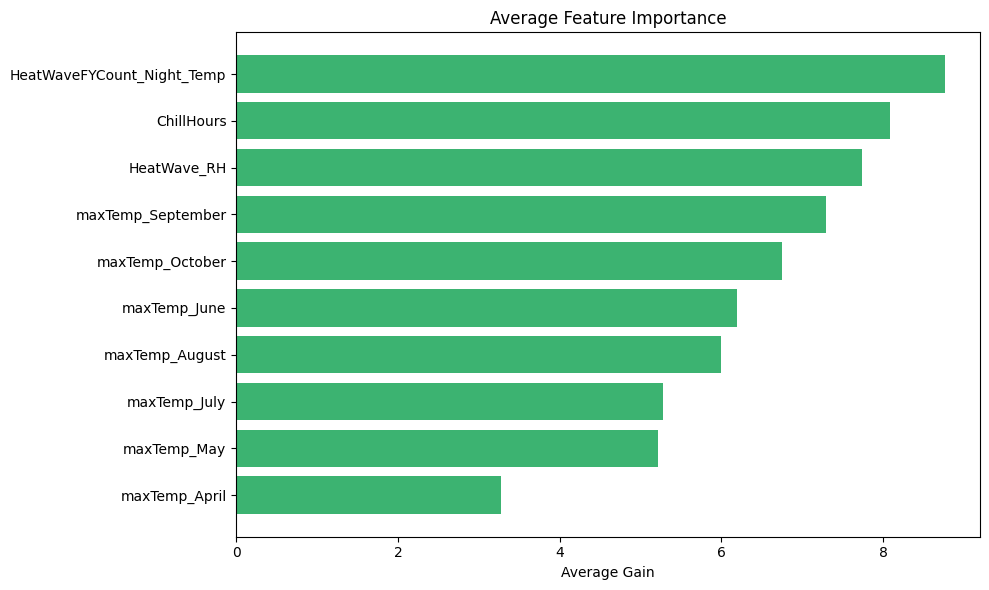

In [78]:
from collections import defaultdict

# נצבור את החשיבויות רק מהמודלים שהצליחו
importance_accumulator = defaultdict(list)

for result in xgboost_results:
    if result['RMSE_Test'] < result['Test_Std']:
        for feature, importance in result['FeatureImportance'].items():
            importance_accumulator[feature].append(importance)

# חשב ממוצע לכל פיצ'ר
average_importance = {
    feature: np.mean(importances)
    for feature, importances in importance_accumulator.items()
}

# העבר לטבלה
importance_df = pd.DataFrame(
    list(average_importance.items()), columns=['Feature', 'AvgImportance']
).sort_values(by='AvgImportance', ascending=False)

# הדפסה
print("\nAverage Feature Importance (only successful models):")
print(importance_df)

# גרף
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['AvgImportance'], color='mediumseagreen')
plt.gca().invert_yaxis()
plt.title("Average Feature Importance")
plt.xlabel("Average Gain")
plt.tight_layout()
plt.show()
